In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tqdm import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


In [2]:
def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]

    cols_to_smooth = ["cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

,areaName,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,latitude,longitude,region,epi_week,recovered,active_cases
0,South West,2020-04-08,120.000000,2091,925.000000,134,237.000000,51.000000,2893.000000,472.000000,5616381,50.96,-3.22,South West England,202015,0.0,2421.000000
1,South West,2020-04-09,119.000000,2212,938.000000,121,241.500000,41.000000,3016.000000,487.500000,5616381,50.96,-3.22,South West England,202015,0.0,2528.500000
2,South West,2020-04-10,121.000000,2343,954.000000,131,239.000000,48.333333,3135.000000,513.666667,5616381,50.96,-3.22,South West England,202015,0.0,2621.333333
3,South West,2020-04-11,121.000000,2470,962.500000,127,222.500000,47.000000,3237.750000,537.500000,5616381,50.96,-3.22,South West England,202015,0.0,2700.250000
4,South West,2020-04-12,122.000000,2599,977.400000,129,213.800000,45.000000,3335.200000,559.200000,5616381,50.96,-3.22,South West England,202016,0.0,2776.000000
5,South West,2020-04-13,121.666667,2712,989.000000,113,210.333333,45.000000,3432.333333,581.166667,5616381,50.96,-3.22,South West England,202016,0.0,2851.166667
6,South West,2020-04-14,121.000000,2818,1001.428571,106,206.714286,43.428571,3528.142857,601.714286,5616381,50.96,-3.22,South West England,202016,0.0,2926.428571
7,South West,2020-04-15,120.571429,2930,1023.571429,112,203.142857,42.000000,3731.285714,643.714286,5616381,50.96,-3.22,South West England,202016,0.0,3087.571429
8,South West,2020-04-16,120.142857,3048,1038.000000,118,205.428571,43.142857,3936.714286,686.857143,5616381,50.96,-3.22,South West England,202016,0.0,3249.857143
9,South West,2020-04-17,118.142857,3150,1047.571429,102,206.285714,41.000000,4143.000000,727.857143,5616381,50.96,-3.22,South West England,202016,0.0,3415.142857


In [24]:
def SEIRD_model(t, y, beta, gamma, delta, sigma, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    dDdt = delta * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, I, R, D

def split_and_scale_data(data, train_size, features, device):
    """Split and scale data into training and validation sets."""
    scaler = MinMaxScaler()
    scaler.fit(data[features])

    # Split data into training and validation sets
    train_data = data.iloc[:train_size].reset_index(drop=True)
    val_data = data.iloc[train_size:].reset_index(drop=True)

    scaled_train_data = pd.DataFrame(scaler.transform(train_data[features]), columns=features)
    scaled_val_data = pd.DataFrame(scaler.transform(val_data[features]), columns=features)

    t_train, I_train, R_train, D_train = prepare_tensors(scaled_train_data, device)
    t_val, I_val, R_val, D_val = prepare_tensors(scaled_val_data, device)

    tensor_data = {
        "train": (t_train, I_train, R_train, D_train),
        "val": (t_val, I_val, R_val, D_val),
    }

    return tensor_data, scaler

# Define features and data split
features = ["active_cases", "recovered", "new_deceased"]
train_size = 65  # days

In [25]:
# Split and scale data
tensor_data, scaler = split_and_scale_data(data, train_size, features, device)

t_train, I_train, R_train, D_train = tensor_data["train"]
t_val, I_val, R_val, D_val = tensor_data["val"]

t_data = torch.cat([t_train, t_val]).requires_grad_(True)
I_data = torch.cat([I_train, I_val])
R_data = torch.cat([R_train, R_val])
D_data = torch.cat([D_train, D_val])

tensor([[7.2462e-02],
        [7.6088e-02],
        [7.9219e-02],
        [8.1881e-02],
        [8.4436e-02],
        [8.6971e-02],
        [8.9509e-02],
        [9.4944e-02],
        [1.0042e-01],
        [1.0599e-01],
        [1.1157e-01],
        [1.1718e-01],
        [1.2276e-01],
        [1.2849e-01],
        [1.3463e-01],
        [1.4090e-01],
        [1.4726e-01],
        [1.5384e-01],
        [1.6073e-01],
        [1.6833e-01],
        [1.7624e-01],
        [1.7276e-01],
        [1.6806e-01],
        [1.6274e-01],
        [1.5685e-01],
        [1.4999e-01],
        [1.4169e-01],
        [1.3216e-01],
        [1.3277e-01],
        [1.3307e-01],
        [1.3281e-01],
        [1.3206e-01],
        [1.3110e-01],
        [1.3069e-01],
        [1.3026e-01],
        [1.2938e-01],
        [1.2806e-01],
        [1.2631e-01],
        [1.2436e-01],
        [1.2195e-01],
        [1.1818e-01],
        [1.1375e-01],
        [1.0888e-01],
        [1.0417e-01],
        [9.9122e-02],
        [9

In [5]:
class SEIRDNet(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, inverse=False, init_beta=None, init_gamma=None, init_delta=None, retain_seed=42, num_layers=4, hidden_neurons=20):
        super(SEIRDNet, self).__init__()
        self.retain_seed = retain_seed
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)
        
        if inverse:
            self._beta = nn.Parameter(torch.tensor([init_beta if init_beta is not None else torch.rand(1)], device=device), requires_grad=True)
            self._gamma = nn.Parameter(torch.tensor([init_gamma if init_gamma is not None else torch.rand(1)], device=device), requires_grad=True)
            self._delta = nn.Parameter(torch.tensor([init_delta if init_delta is not None else torch.rand(1)], device=device), requires_grad=True)
        else:
            self._beta = None
            self._gamma = None
            self._delta = None
        
        self.init_xavier()

    def forward(self, t):
        return self.net(t)

    @property
    def beta(self):
        return torch.sigmoid(self._beta) * 0.9 + 0.1 if self._beta is not None else None

    @property
    def gamma(self):
        return torch.sigmoid(self._gamma) * 0.09 + 0.01 if self._gamma is not None else None
    
    @property
    def delta(self):
        return torch.sigmoid(self._delta) * 0.09 + 0.01 if self._delta is not None else None
    
    def init_xavier(self):
        torch.manual_seed(self.retain_seed)
        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain('tanh')
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)
        self.apply(init_weights)

In [6]:
def pinn_loss(t, I_data, R_data, D_data, train_size, parameters, model_output, N, sigma=None):
    """Physics-Informed Neural Network loss function."""
    
    S = N - I_data - R_data - D_data # Susceptible population  
    beta, gamma, delta = parameters # Unpack parameters
    
    # Compute gradients
    S_pred, E_pred, I_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4] # Unpack model output
    
    # Compute first order derivatives
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # Compute derivatives of the differential equations
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta, gamma, delta, sigma, N)
    
    # Compute loss on the data using training data over all time points
    loss_data = torch.mean((I_pred[:train_size] - I_data[:train_size])**2) + torch.mean((R_pred[:train_size] - R_data[:train_size])**2) + torch.mean((D_pred[:train_size] - D_data[:train_size])**2)
    
    # Compute loss on the physics using training data over all time points
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((E_t - dEdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)  
    
    # initial condition loss
    loss_init = torch.mean((S_pred[0] - N)**2) + torch.mean((E_pred[0])**2) + torch.mean((I_pred[0])**2) + torch.mean((R_pred[0])**2) + torch.mean((D_pred[0])**2)
    
    # boundary condition loss
    loss_boundary = torch.mean((S_pred[t-1] - S_pred[0])**2) + torch.mean((E_pred[t-1])**2) + torch.mean((I_pred[t-1])**2) + torch.mean((R_pred[t-1])**2) + torch.mean((D_pred[t-1])**2)
    
    # regularization loss
    loss_reg = torch.mean(beta**2) + torch.mean(gamma**2) + torch.mean(delta**2)
    
    total_loss = loss_data + loss_physics + loss_init + loss_boundary + loss_reg
    
    return total_loss


In [7]:
class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Initialize the models
model = SEIRDNet(num_layers=6, hidden_neurons=32, init_beta=0.1, init_delta=0.01, init_gamma=0.01, inverse=True).to(device)

# Initialize the optimizers
model_optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler
scheduler = StepLR(model_optimizer, step_size=2000, gamma=0.9)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Loss history
loss_history = []

# Total population
N = data["population"].values[0]

In [8]:
def train_model(tensor_data, model, model_optimizer, scheduler, early_stopping, num_epochs=1000):
    """Training loop for the model."""
    for epoch in tqdm(range(num_epochs)):
        model.train()
        
        model_optimizer.zero_grad()
        
        params = [model.beta, model.gamma, model.delta]
        
        t_train, I_train, R_train, D_train = tensor_data["train"]
        t_val, I_val, R_val, D_val = tensor_data["val"]

        t_data = torch.cat([t_train, t_val]).requires_grad_(True)
        t_data = torch.cat([I_train, I_val])
        R_data = torch.cat([R_train, R_val])
        D_data = torch.cat([D_train, D_val])
        
        # Shuffle the training indices
        idx = torch.randperm(t_train.size(0))
        t_train_shuffled = t_train[idx]

        model_output = model(t_train)

        loss = pinn_loss(t_data, t_data, R_data, D_data, t_train_shuffled, params, model_output, N, sigma=1/5)
        loss.backward()
        
        model_optimizer.step()
        
        scheduler.step()

        loss_history.append(loss.item())

        if early_stopping(loss.item()):
            print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
            break

        if epoch % 500 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}: Loss: {loss.item():.6f}")

    print("Finished Training")
    return loss_history, model

In [9]:
# train the model
loss_history, model = train_model(tensor_data, model, model_optimizer, scheduler, early_stopping, num_epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: One of the differentiated Tensors does not require grad

In [ ]:
# def pinn_loss(t_data, I_data, R_data, D_data, tensor_data, parameters, model_output, t, N, sigma=None):
#     """Compute the PINN loss."""
#     t.requires_grad_(True)
#     S = N - I_data - R_data - D_data
#     beta, gamma, delta = parameters
#     dSdt, dEdt, dIdt, dRdt, dDdt = model_output

#     # Compute the loss
#     loss = nn.MSELoss()(dIdt, -sigma * dEdt)
#     loss += nn.MSELoss()(dRdt, gamma * I_data)
#     loss += nn.MSELoss()(dDdt, delta * I_data)
#     loss += nn.MSELoss()(dSdt, -beta * S * I_data / N)
#     loss += nn.MSELoss()(dEdt, beta * S * I_data / N - sigma * dEdt)

#     # Compute the gradients
#     grads = grad(loss, parameters, create_graph=True)

#     # Compute the second-order derivatives
#     grad_grads = grad(grads[0].sum(), parameters, create_graph=True)

#     # Compute the residual loss
#     loss += nn.MSELoss()(grads[0].sum(), torch.zeros_like(grads[0]))
#     loss += nn.MSELoss()(grad_grads[0].sum(), torch.zeros_like(grad_grads[0]))

#     return loss

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tqdm import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["cumulative_confirmed"] - df["cumulative_deceased"] - df["recovered"]

    cols_to_smooth = ["S(t)","cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

def SEIRD_model(t, y, beta, gamma, delta, sigma, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    dDdt = delta * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, S, I, R, D

def split_and_scale_data(data, train_size, features, device):
    """Split and scale data into training and validation sets."""
    scaler = MinMaxScaler()
    scaler.fit(data[features])

    # Split data into training and validation sets
    train_data = data.iloc[:train_size].reset_index(drop=True)
    val_data = data.iloc[train_size:].reset_index(drop=True)

    scaled_train_data = pd.DataFrame(scaler.transform(train_data[features]), columns=features)
    scaled_val_data = pd.DataFrame(scaler.transform(val_data[features]), columns=features)

    t_train, S_train, I_train, R_train, D_train = prepare_tensors(scaled_train_data, device)
    t_val, S_val, I_val, R_val, D_val = prepare_tensors(scaled_val_data, device)

    tensor_data = {
        "train": (t_train, S_train, I_train, R_train, D_train),
        "val": (t_val, S_val, I_val, R_val, D_val),
    }

    return tensor_data, scaler

# Define features and data split
features = ["S(t)", "active_cases", "recovered", "new_deceased"]
train_size = 65  # days

# Split and scale data
tensor_data, scaler = split_and_scale_data(data, train_size, features, device)

t_train, S_train, I_train, R_train, D_train = tensor_data["train"]
t_val, S_val, I_val, R_val, D_val = tensor_data["val"]    

t_data = torch.cat([t_train, t_val])
S_data = torch.cat([S_train, S_val])    
I_data = torch.cat([I_train, I_val])
R_data = torch.cat([R_train, R_val])
D_data = torch.cat([D_train, D_val])

class SEIRDNet(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, inverse=False, init_beta=None, init_gamma=None, init_delta=None, retain_seed=42, num_layers=4, hidden_neurons=20):
        super(SEIRDNet, self).__init__()
        self.retain_seed = retain_seed
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)
        
        if inverse:
            self._beta = nn.Parameter(torch.tensor([init_beta if init_beta is not None else torch.rand(1)], device=device), requires_grad=True)
            self._gamma = nn.Parameter(torch.tensor([init_gamma if init_gamma is not None else torch.rand(1)], device=device), requires_grad=True)
            self._delta = nn.Parameter(torch.tensor([init_delta if init_delta is not None else torch.rand(1)], device=device), requires_grad=True)
        else:
            self._beta = None
            self._gamma = None
            self._delta = None
        
        self.init_xavier()

    def forward(self, t):
        return self.net(t)

    @property
    def beta(self):
        return torch.sigmoid(self._beta) * 0.9 + 0.1 if self._beta is not None else None

    @property
    def gamma(self):
        return torch.sigmoid(self._gamma) * 0.09 + 0.01 if self._gamma is not None else None
    
    @property
    def delta(self):
        return torch.sigmoid(self._delta) * 0.09 + 0.01 if self._delta is not None else None
    
    def init_xavier(self):
        torch.manual_seed(self.retain_seed)
        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain('tanh')
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)
        self.apply(init_weights)

def pinn_loss(t, tensor_data, parameters, model_output, N, sigma=None):
    """Physics-Informed Neural Network loss function."""
    
    # S_data = N - I_data - R_data - D_data # Susceptible population  
    beta, gamma, delta = parameters # Unpack parameters
    
    # extract data  
    S_data, I_data, R_data, D_data = tensor_data    
    
    # Compute gradients
    S_pred, E_pred, I_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4] # Unpack model output
    
    # Compute first order derivatives
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # Compute derivatives of the differential equations
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta, gamma, delta, sigma, N)
    
    # Compute data loss
    loss_data = torch.mean((S_pred - S_data)**2) + torch.mean((I_pred - I_data)**2) + torch.mean((R_pred - R_data)**2) + torch.mean((D_pred - D_data)**2)
    
    # Compute loss on the physics using training data over all time points
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((E_t - dEdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)
    
    # initial condition loss
    loss_init = torch.mean((S_pred[0] - N)**2) + torch.mean((E_pred[0])**2) + torch.mean((I_pred[0])**2) + torch.mean((R_pred[0])**2) + torch.mean((D_pred[0])**2)
    
    # # boundary condition loss
    loss_boundary = torch.mean((S_pred[t-1] - S_pred[0])**2) + torch.mean((E_pred[t-1])**2) + torch.mean((I_pred[t-1])**2) + torch.mean((R_pred[t-1])**2) + torch.mean((D_pred[t-1])**2)
    
    # regularization loss
    loss_reg = torch.mean(beta**2) + torch.mean(gamma**2) + torch.mean(delta**2)
    
    total_loss = loss_data + loss_physics + loss_init + loss_reg + loss_boundary
    
    return total_loss

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Initialize the models
model = SEIRDNet(num_layers=6, hidden_neurons=32, init_beta=0.1, init_delta=0.01, init_gamma=0.01, inverse=True).to(device)

# Initialize the optimizers
model_optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)

# Learning rate scheduler
scheduler = StepLR(model_optimizer, step_size=2000, gamma=0.9)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Loss history
loss_history = []

# Total population
N = data["population"].values[0]

def train_model(tensor_data, model, model_optimizer, scheduler, early_stopping, num_epochs=1000):
    """Training loop for the model."""
    for epoch in tqdm(range(num_epochs)):
        model.train()
        
        model_optimizer.zero_grad()
        
        params = [model.beta, model.gamma, model.delta]
        
        t_train, S_train, I_train, R_train, D_train = tensor_data["train"]
        t_val, S_val, I_val, R_val, D_val = tensor_data["val"]

        t_data = torch.cat([t_train, t_val]).requires_grad_(True)
        S_data = torch.cat([S_train, S_val])
        I_data = torch.cat([I_train, I_val])
        R_data = torch.cat([R_train, R_val])
        D_data = torch.cat([D_train, D_val])
        
        # Shuffle the training indices
        idx = torch.randperm(t_train.size(0))
        t_train_shuffled = t_train[idx]

        model_output = model(t_train)

        loss = pinn_loss(t_data, [S_data, I_data, R_data, D_data], params, model_output, N, sigma=1/5)
        loss.backward()
        
        model_optimizer.step()
        
        scheduler.step()

        loss_history.append(loss.item())

        if early_stopping(loss.item()):
            print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
            break

        if epoch % 500 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}: Loss: {loss.item():.6f}")
            
        return loss_history, model 
    
# train the model
loss_history, model = train_model(tensor_data, model, model_optimizer, scheduler, early_stopping, num_epochs=5000)


Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

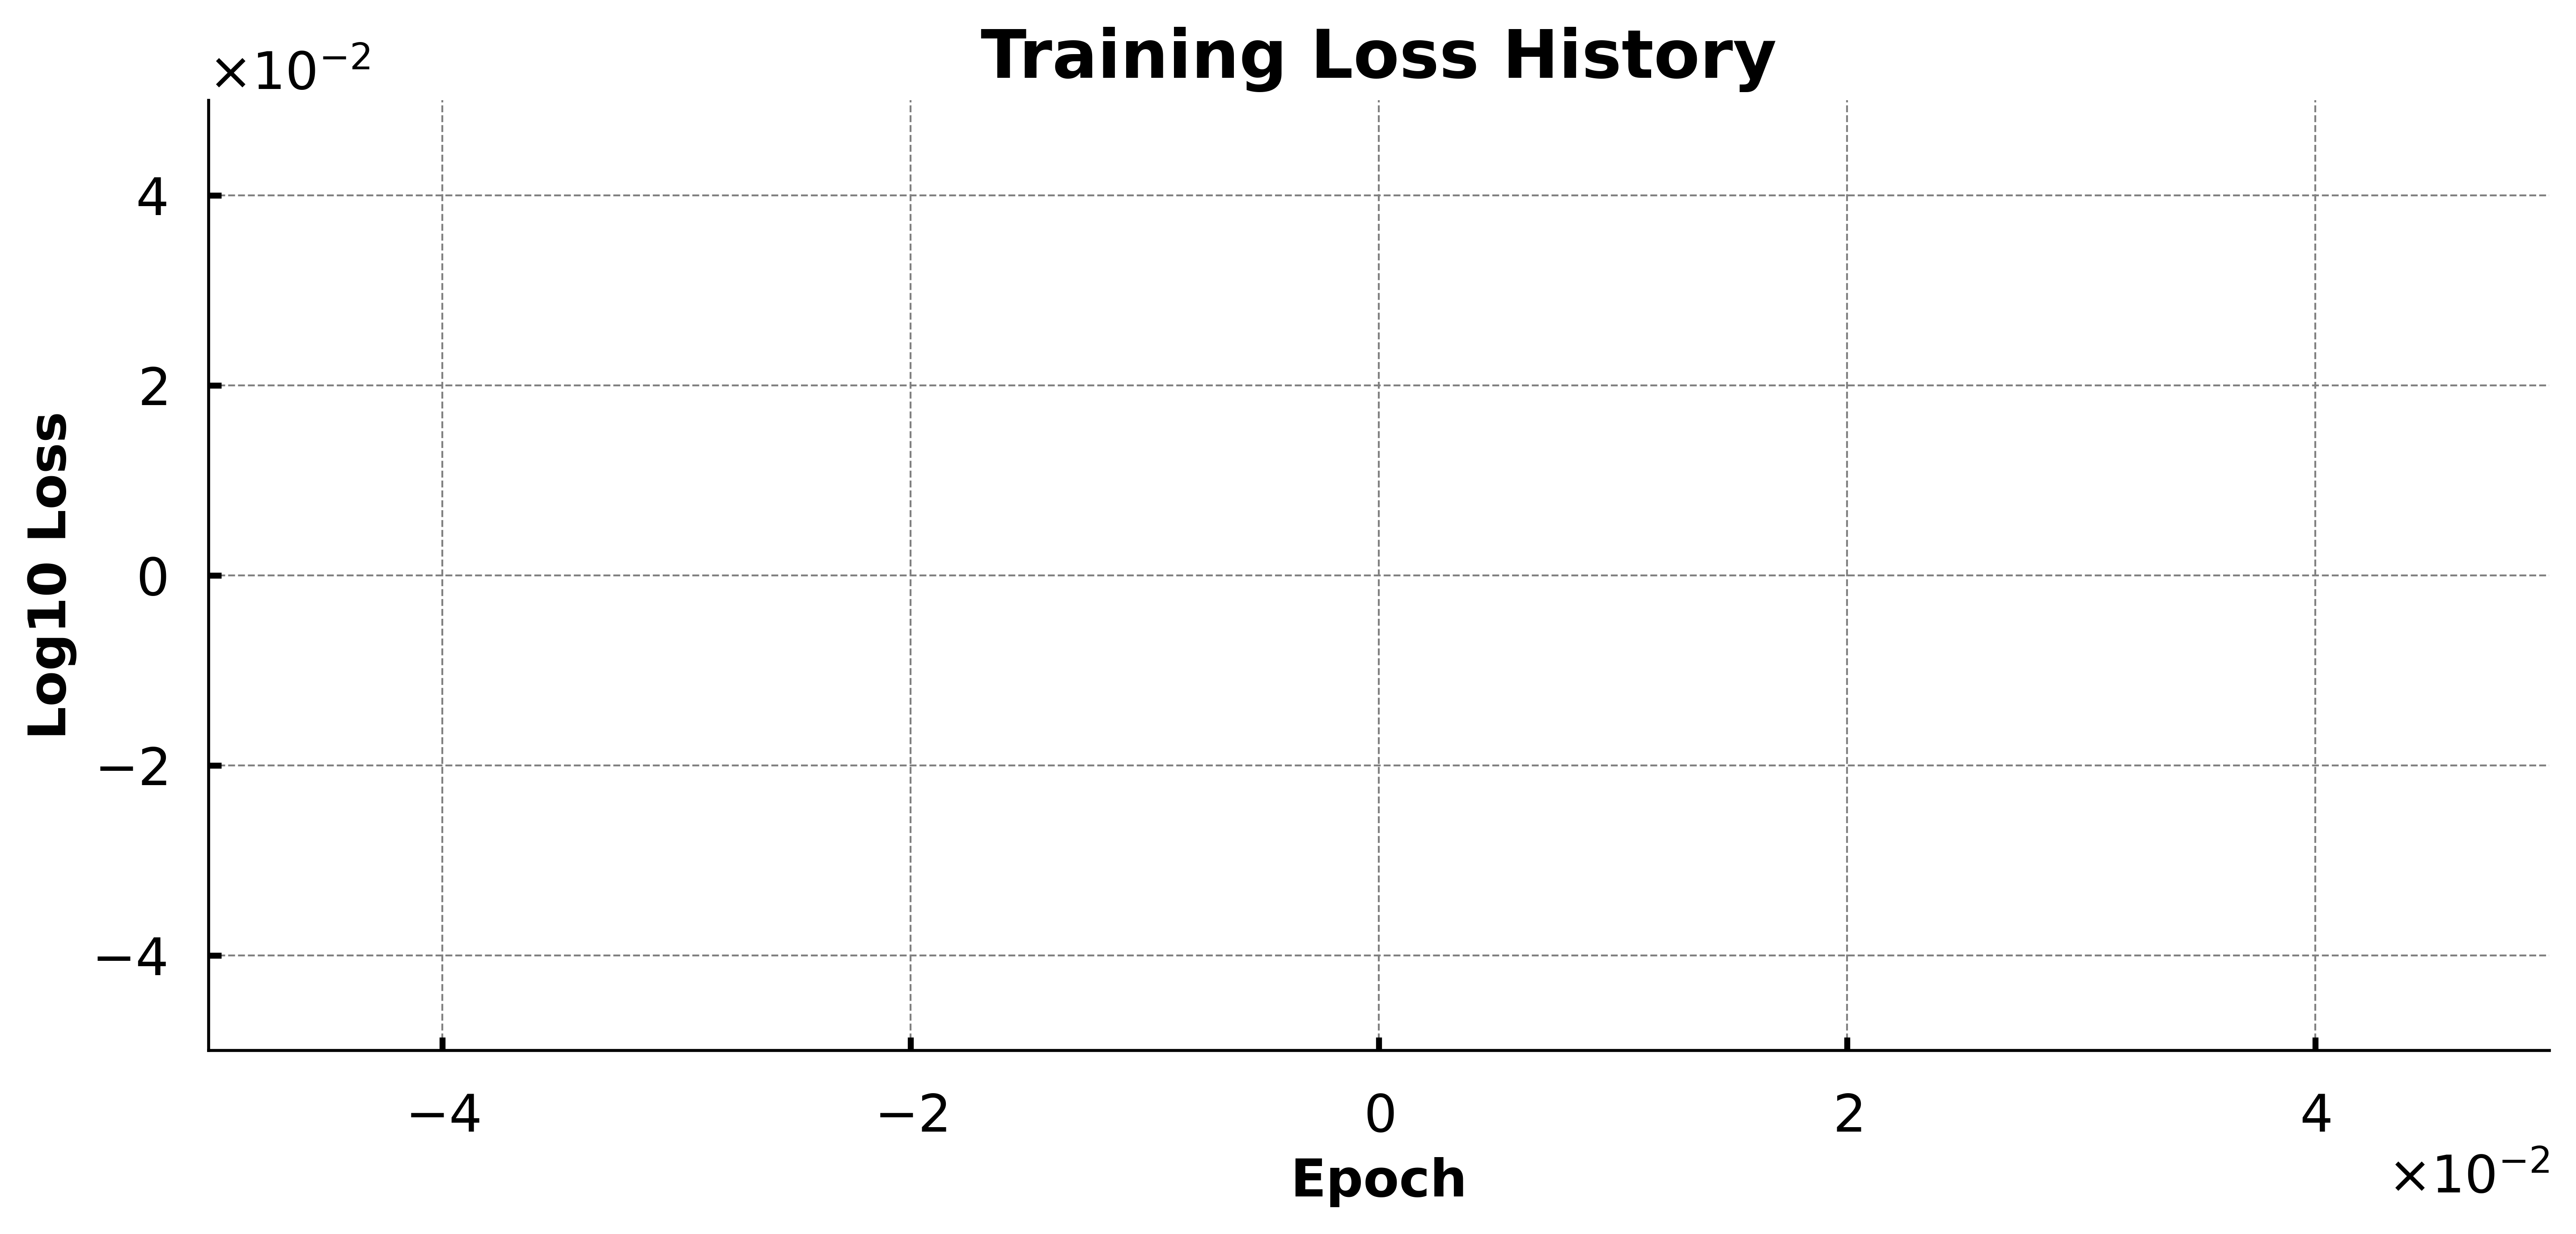

In [45]:
# loss history 
plt.plot(np.log10(loss_history))
plt.xlabel("Epoch")
plt.ylabel("Log10 Loss")
plt.title("Training Loss History")
plt.show()  


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["cumulative_confirmed"] - df["cumulative_deceased"] - df["recovered"]

    cols_to_smooth = ["S(t)","cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

def SEIRD_model(t, y, beta, gamma, mu, sigma, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, S, I, R, D

def split_and_scale_data(data, train_size, features, device):
    """Split and scale data into training and validation sets."""
    scaler = MinMaxScaler()
    scaler.fit(data[features])

    # Split data into training and validation sets
    train_data = data.iloc[:train_size].reset_index(drop=True)
    val_data = data.iloc[train_size:].reset_index(drop=True)

    scaled_train_data = pd.DataFrame(scaler.transform(train_data[features]), columns=features)
    scaled_val_data = pd.DataFrame(scaler.transform(val_data[features]), columns=features)

    t_train, S_train, I_train, R_train, D_train = prepare_tensors(scaled_train_data, device)
    t_val, S_val, I_val, R_val, D_val = prepare_tensors(scaled_val_data, device)

    tensor_data = {
        "train": (t_train, S_train, I_train, R_train, D_train),
        "val": (t_val, S_val, I_val, R_val, D_val),
    }

    return tensor_data, scaler

# Define features and data split
features = ["S(t)", "active_cases", "recovered", "new_deceased"]
train_size = 65  # days

# Split and scale data
tensor_data, scaler = split_and_scale_data(data, train_size, features, device)

t_train, S_train, I_train, R_train, D_train = tensor_data["train"]
t_val, S_val, I_val, R_val, D_val = tensor_data["val"]    

t_data = torch.cat([t_train, t_val])
S_data = torch.cat([S_train, S_val])
I_data = torch.cat([I_train, I_val])
R_data = torch.cat([R_train, R_val])
D_data = torch.cat([D_train, D_val])

class ModifiedTanh(nn.Module):
    def __init__(self, alpha, epsilon):
        super(ModifiedTanh, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon

    def forward(self, x):
        return torch.tanh(self.alpha * x) + self.epsilon

class StateNN(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, num_layers=4, hidden_neurons=20):
        super(StateNN, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

class ParamNN(nn.Module):
    """Neural network for predicting time-varying parameters."""
    def __init__(self, num_layers=4, hidden_neurons=20, alpha=1.0, epsilon=0.0):
        super(ParamNN, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon
        layers = [nn.Linear(1, hidden_neurons), ModifiedTanh(alpha, epsilon)]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), ModifiedTanh(alpha, epsilon)])
        layers.append(nn.Linear(hidden_neurons, 3))  # Adjust the output size to 3 (beta, gamma, mu)
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

def pinn_loss(t, data, state_nn, param_nn, N, sigma):
    """Physics-Informed Neural Network loss function."""
    
    # Predicted states
    states_pred = state_nn(t)
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]
    
    # Compute gradients
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # Predicted parameters
    params_pred = param_nn(t)
    beta_pred, gamma_pred, mu_pred = params_pred[:, 0], params_pred[:, 1], params_pred[:, 2]
    
    # SEIRD model residuals
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta_pred, gamma_pred, mu_pred, sigma, N)
    
    # Compute E dynamically
    E_calculated = I_t + (gamma_pred + mu_pred) * I_pred - sigma * E_pred
    
    # Compute data loss (MSE_u)
    S_data, I_data, R_data, D_data = data
    loss_data = torch.mean((S_pred - S_data)**2) + torch.mean((I_pred - I_data)**2) + torch.mean((R_pred - R_data)**2) + torch.mean((D_pred - D_data)**2)
    
    # Compute physics loss (MSE_f)
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((E_t - dEdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)
    
    # Total loss
    total_loss = loss_data + loss_physics
    
    return total_loss

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Hyperparameters
learning_rate = 1e-4
num_epochs = 5000
sigma = 1/5
N = data["population"].values[0]
alpha = 0.5
epsilon = 0.1

# Instantiate the neural networks with custom activation function
state_nn = StateNN(num_layers=6, hidden_neurons=32).to(device)
param_nn = ParamNN(num_layers=6, hidden_neurons=32, alpha=alpha, epsilon=epsilon).to(device)

# Optimizers
optimizer_state = optim.Adam(state_nn.parameters(), lr=learning_rate)
optimizer_param = optim.Adam(param_nn.parameters(), lr=learning_rate)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Training loop
loss_history = []
for epoch in tqdm(range(num_epochs)):
    state_nn.train()
    param_nn.train()
    
    optimizer_state.zero_grad()
    optimizer_param.zero_grad()
    
    # Prepare time tensor
    t = torch.linspace(0, 1, steps=len(data)).view(-1, 1).to(device).requires_grad_(True)
    
    # Prepare data tensor
    S_data = torch.tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I_data = torch.tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R_data = torch.tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D_data = torch.tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    
    data_tensors = (S_data, I_data, R_data, D_data)
    
    # Compute loss
    loss = pinn_loss(t, data_tensors, state_nn, param_nn, N, sigma)
    
    # Backpropagation
    loss.backward()
    
    optimizer_state.step()
    optimizer_param.step()
    
    loss_history.append(loss.item())
    
    if epoch % 500 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}")
    
    if early_stopping(loss.item()):
        print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
        break

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(np.log10(loss_history), label="Training Loss")    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 6/5000 [00:00<01:41, 49.39it/s]

Epoch [0/5000], Loss: 30976105250816.000000


  7%|▋         | 363/5000 [00:08<01:54, 40.51it/s]


KeyboardInterrupt: 

Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 5/5000 [00:00<01:55, 43.09it/s]

Epoch [0/5000], Loss: 30976105250816.000000


 10%|█         | 505/5000 [00:11<01:44, 43.21it/s]

Epoch [500/5000], Loss: 30976048627712.000000


 20%|██        | 1006/5000 [00:23<01:32, 43.26it/s]

Epoch [1000/5000], Loss: 30976017170432.000000


 30%|███       | 1507/5000 [00:34<01:20, 43.62it/s]

Epoch [1500/5000], Loss: 30976002490368.000000


 40%|████      | 2007/5000 [00:46<01:09, 43.08it/s]

Epoch [2000/5000], Loss: 30975977324544.000000


 50%|█████     | 2507/5000 [00:57<00:58, 42.98it/s]

Epoch [2500/5000], Loss: 30975960547328.000000


 60%|██████    | 3007/5000 [01:09<00:46, 43.23it/s]

Epoch [3000/5000], Loss: 30975941672960.000000


 70%|███████   | 3507/5000 [01:21<00:34, 43.11it/s]

Epoch [3500/5000], Loss: 30975922798592.000000


 80%|████████  | 4007/5000 [01:32<00:23, 43.05it/s]

Epoch [4000/5000], Loss: 30975903924224.000000


 90%|█████████ | 4508/5000 [01:45<00:12, 38.13it/s]

Epoch [4500/5000], Loss: 30975889244160.000000


100%|██████████| 5000/5000 [01:56<00:00, 42.93it/s]


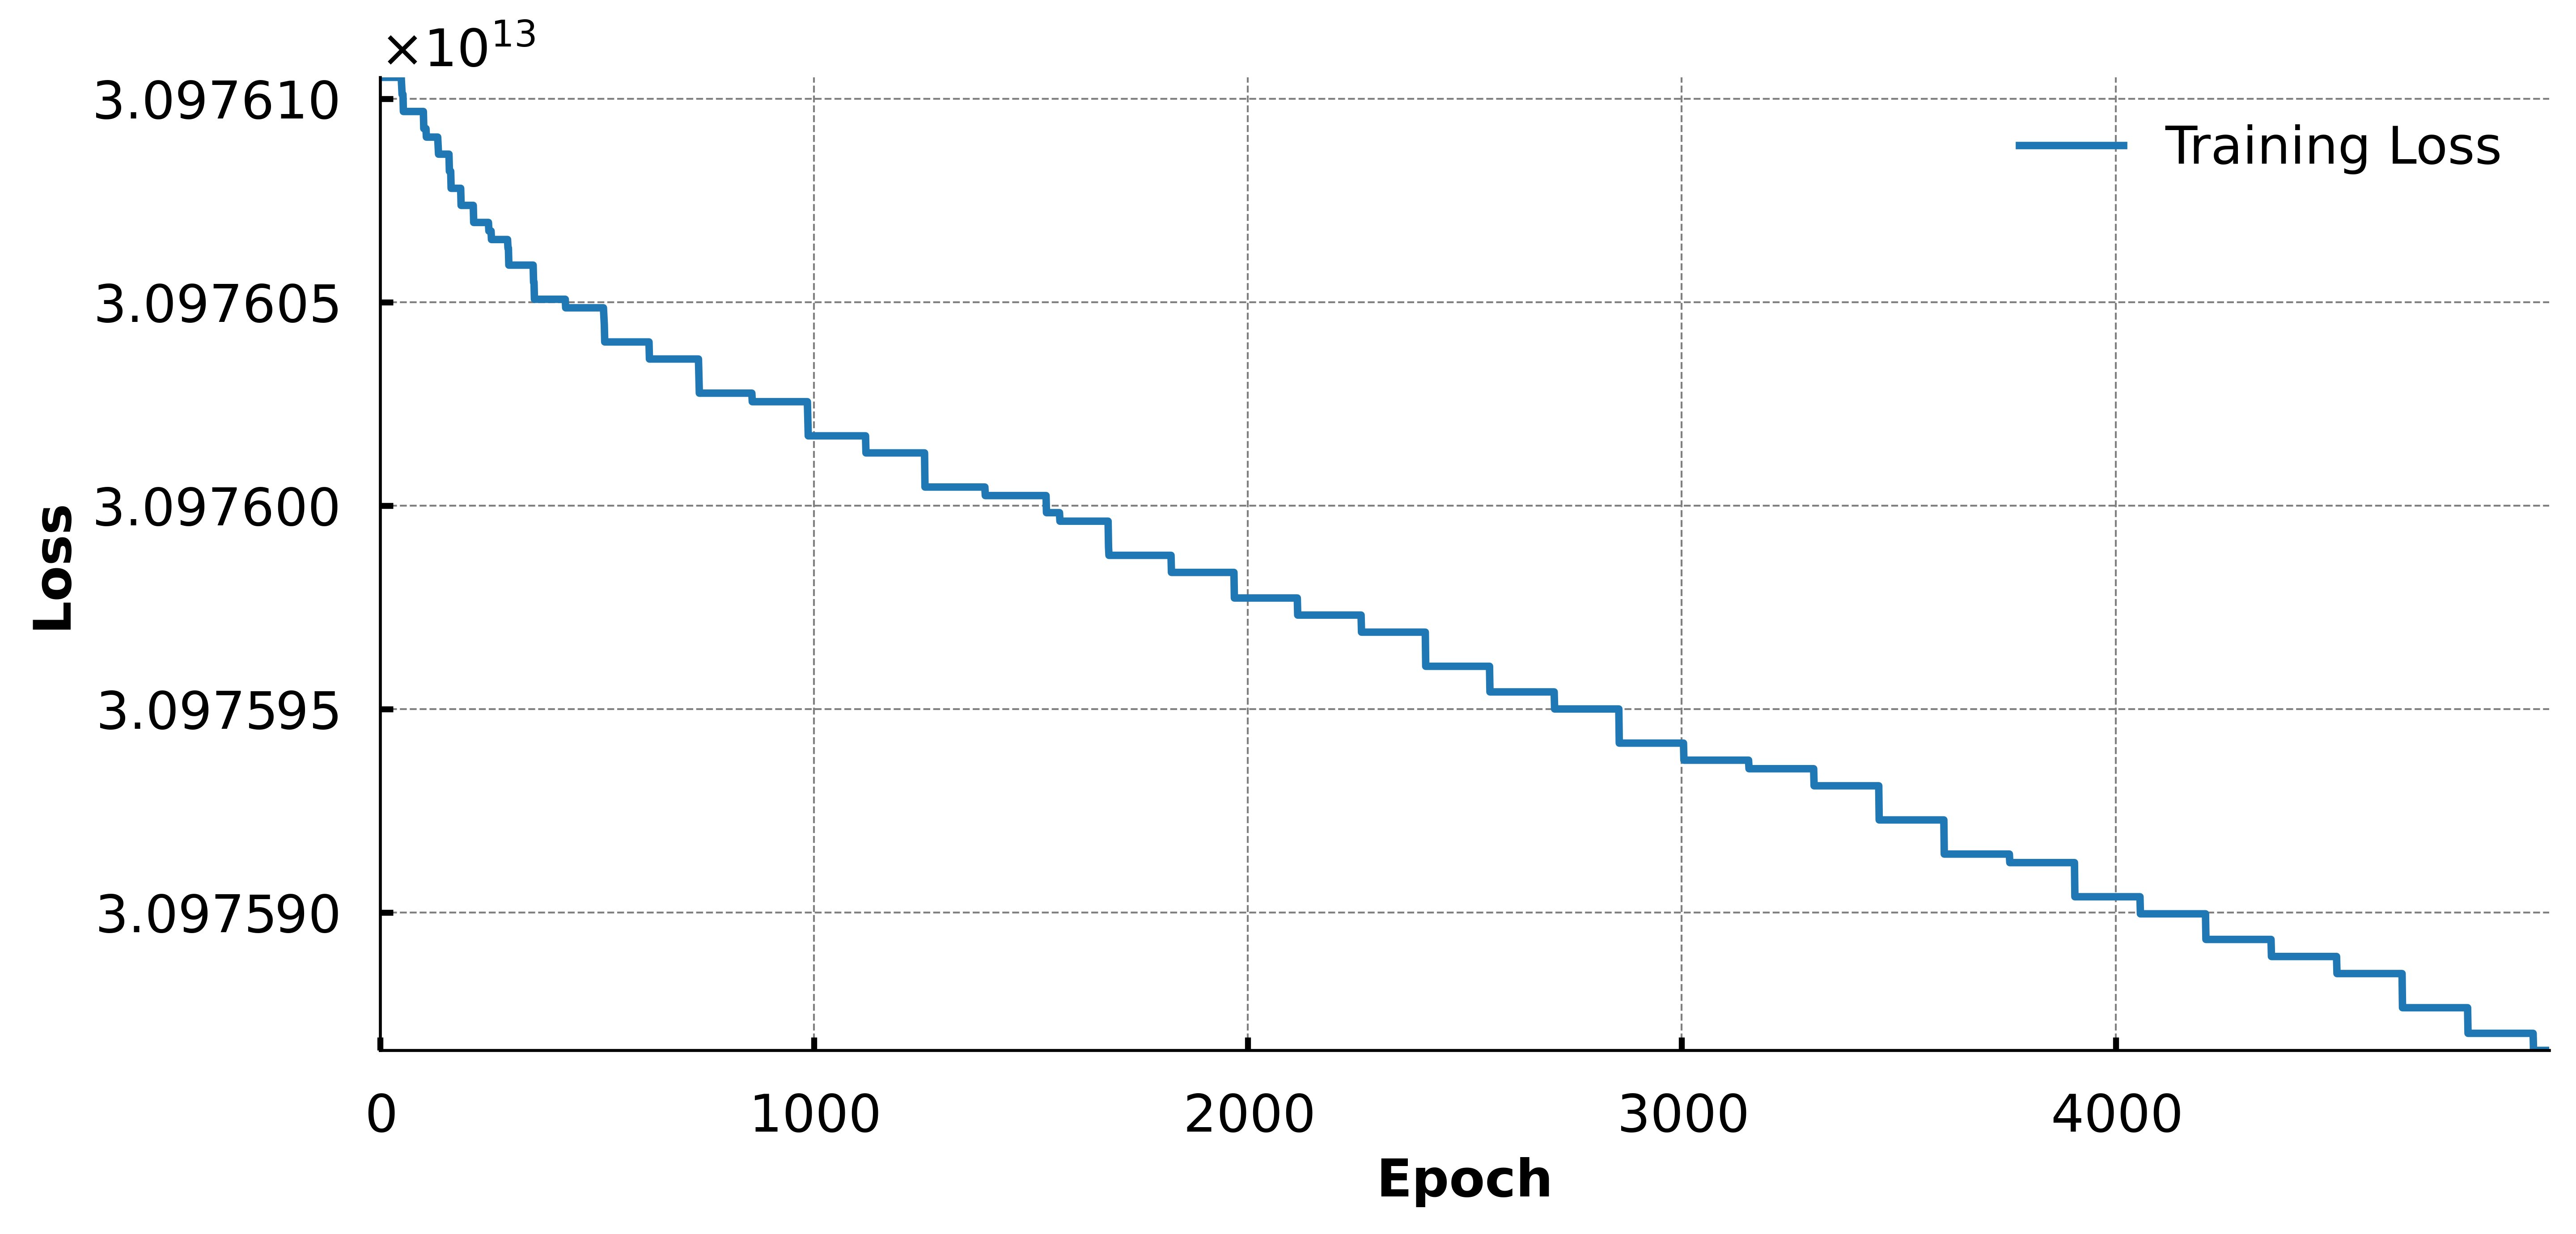

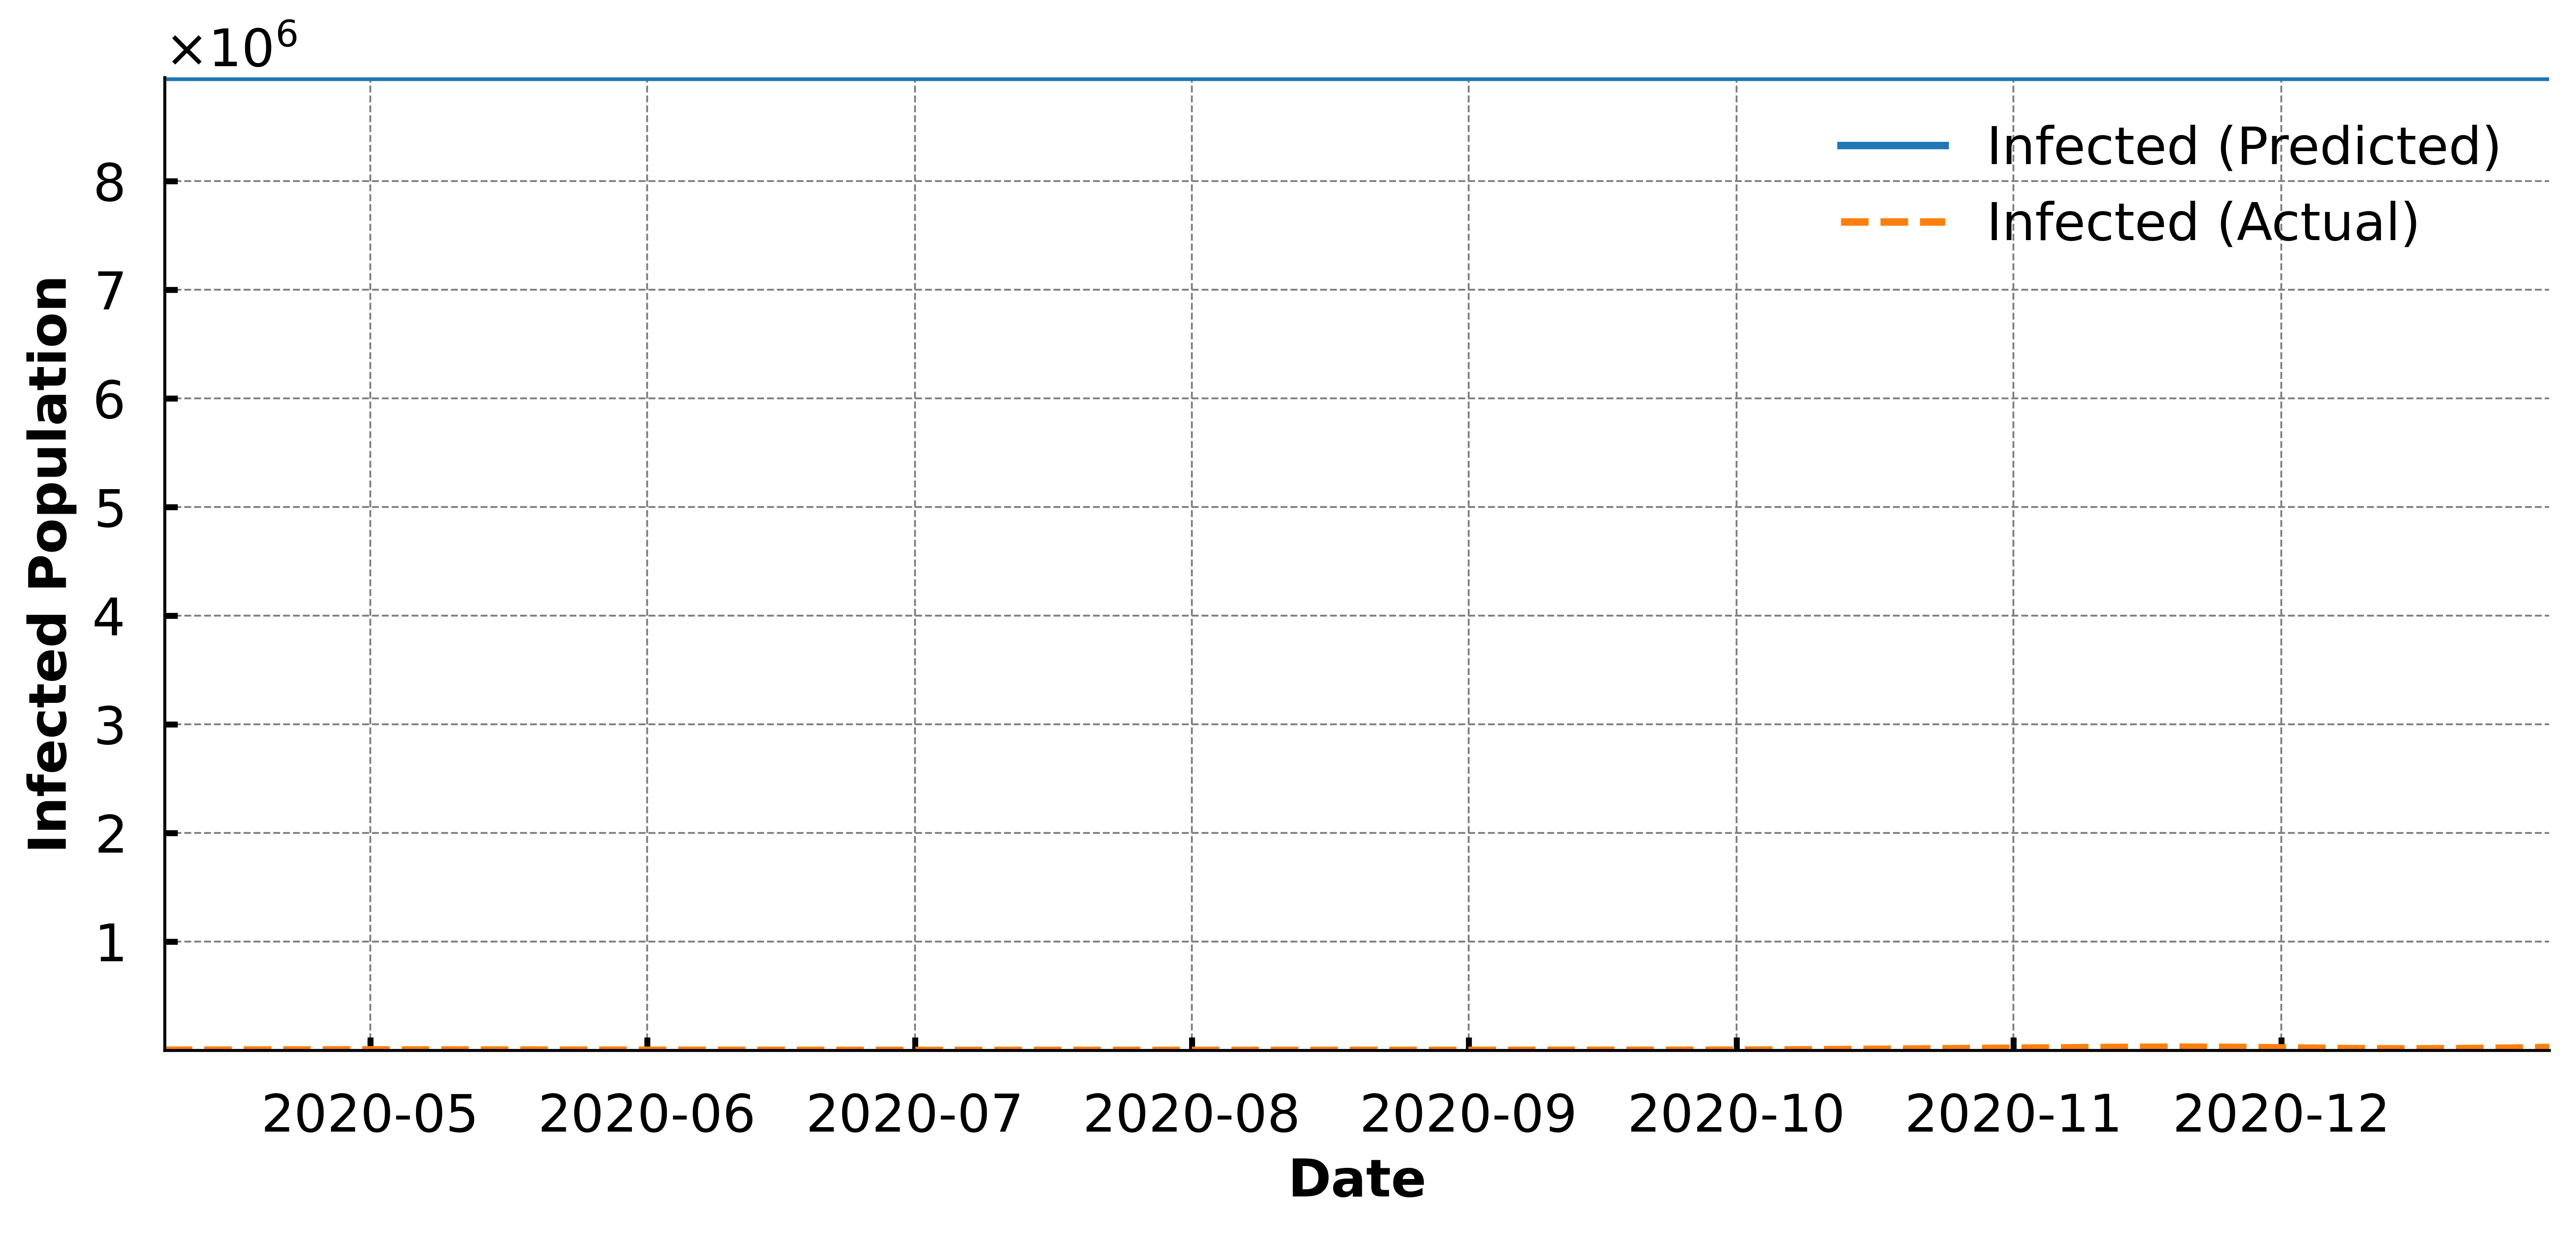

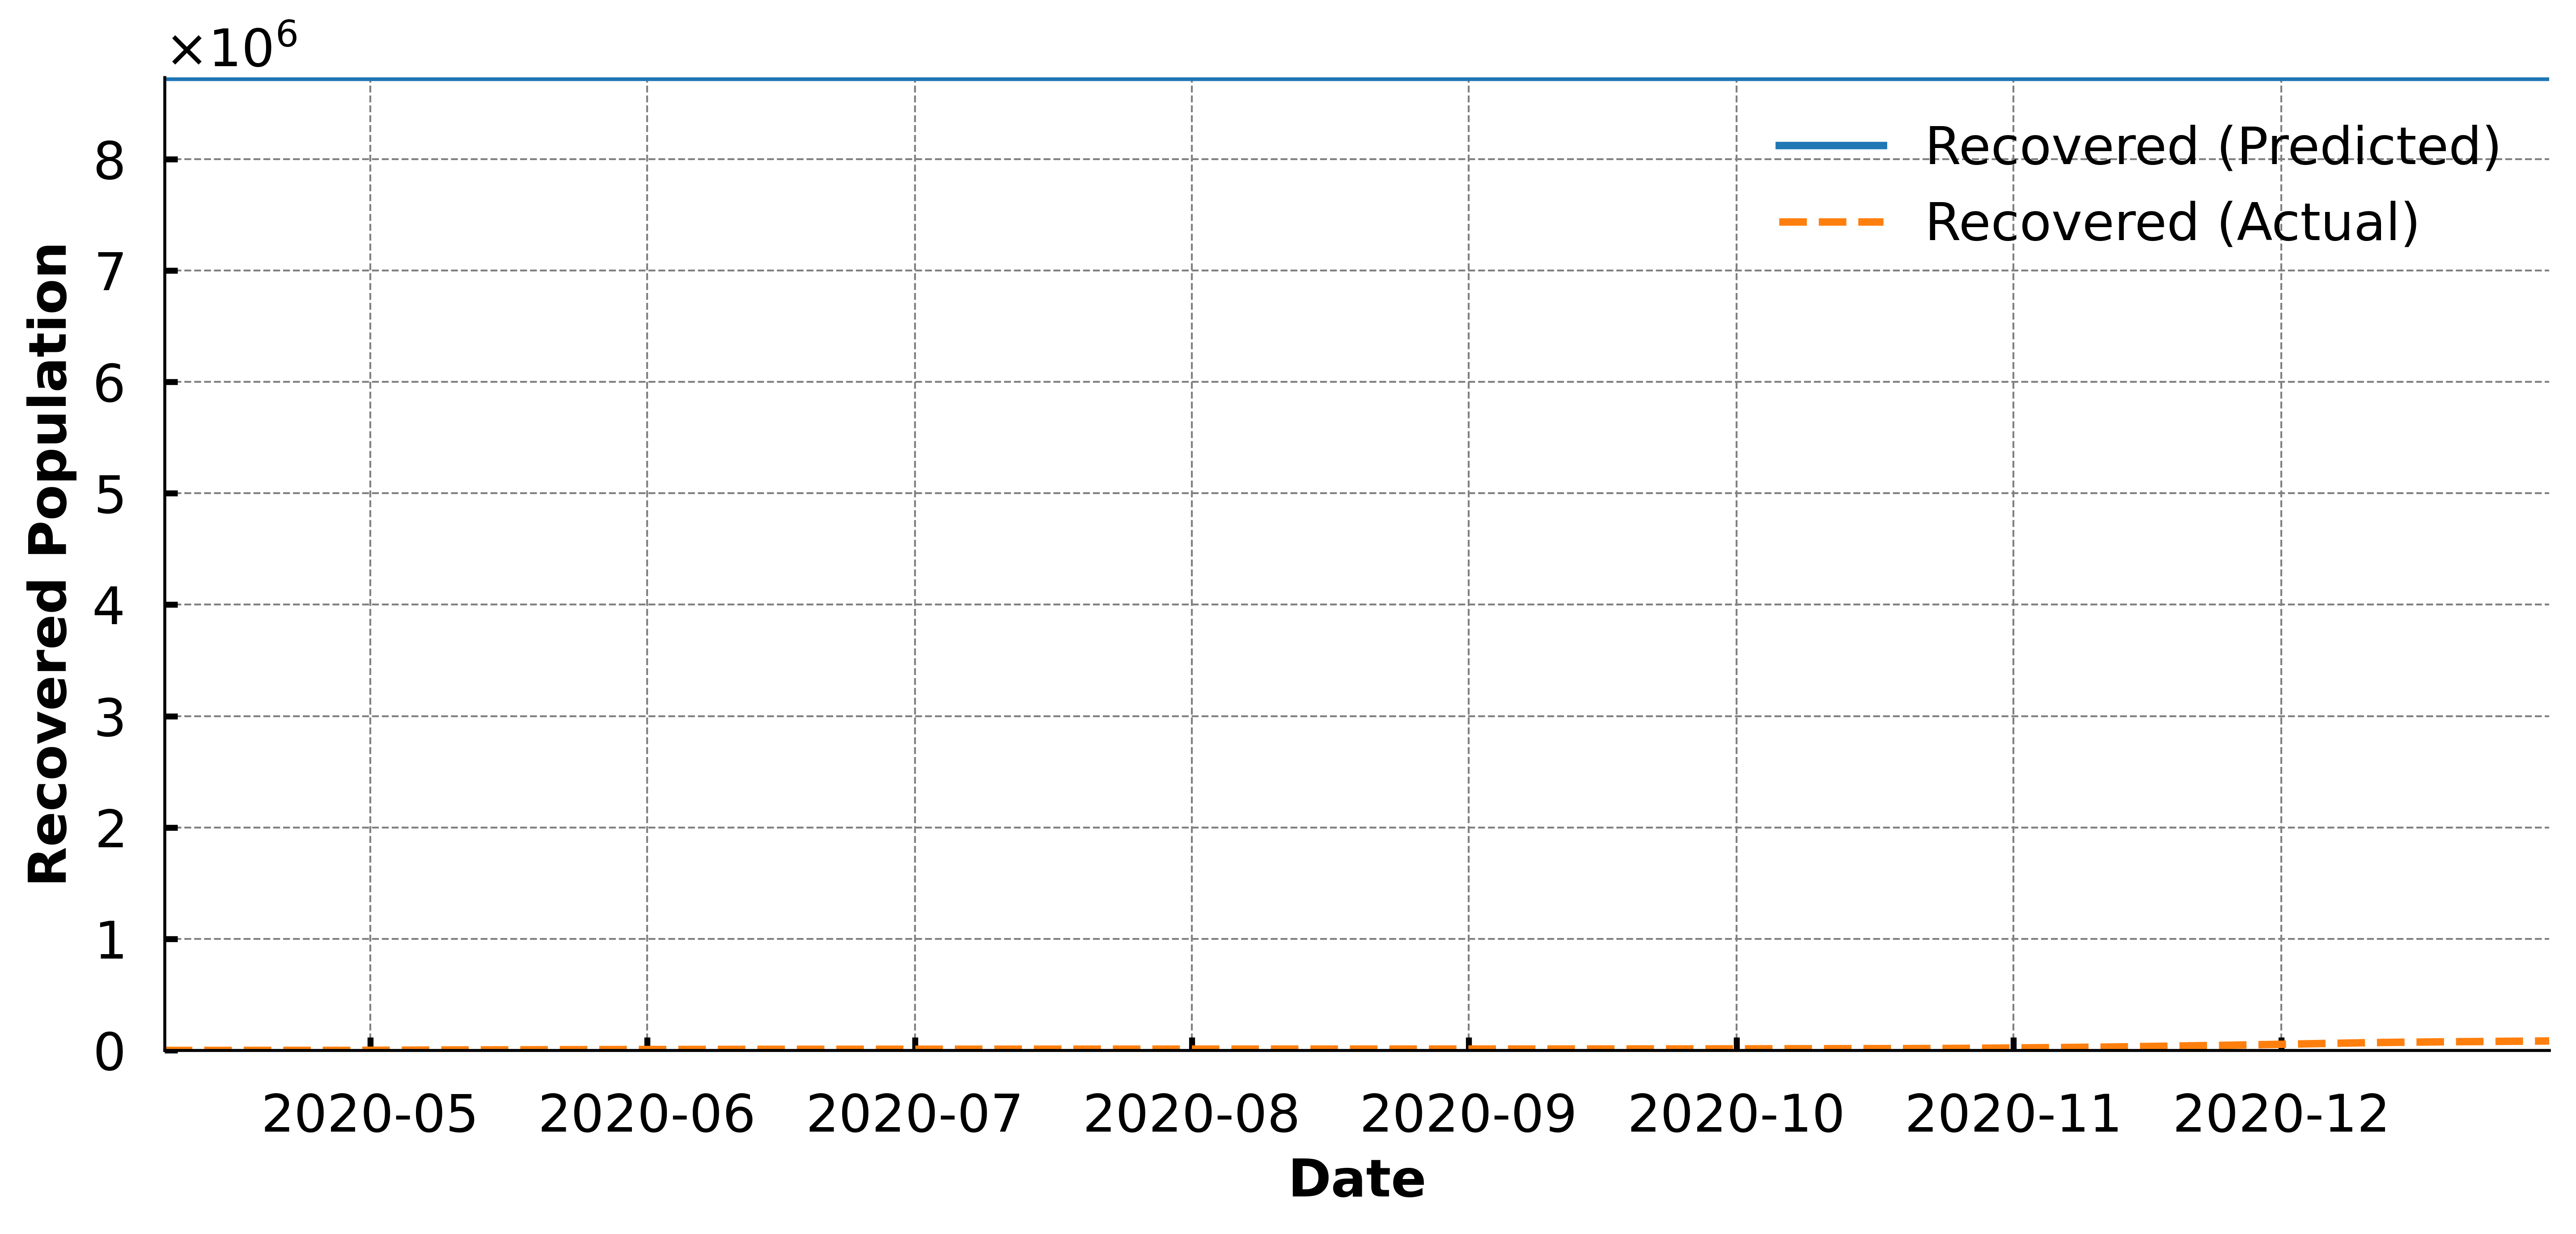

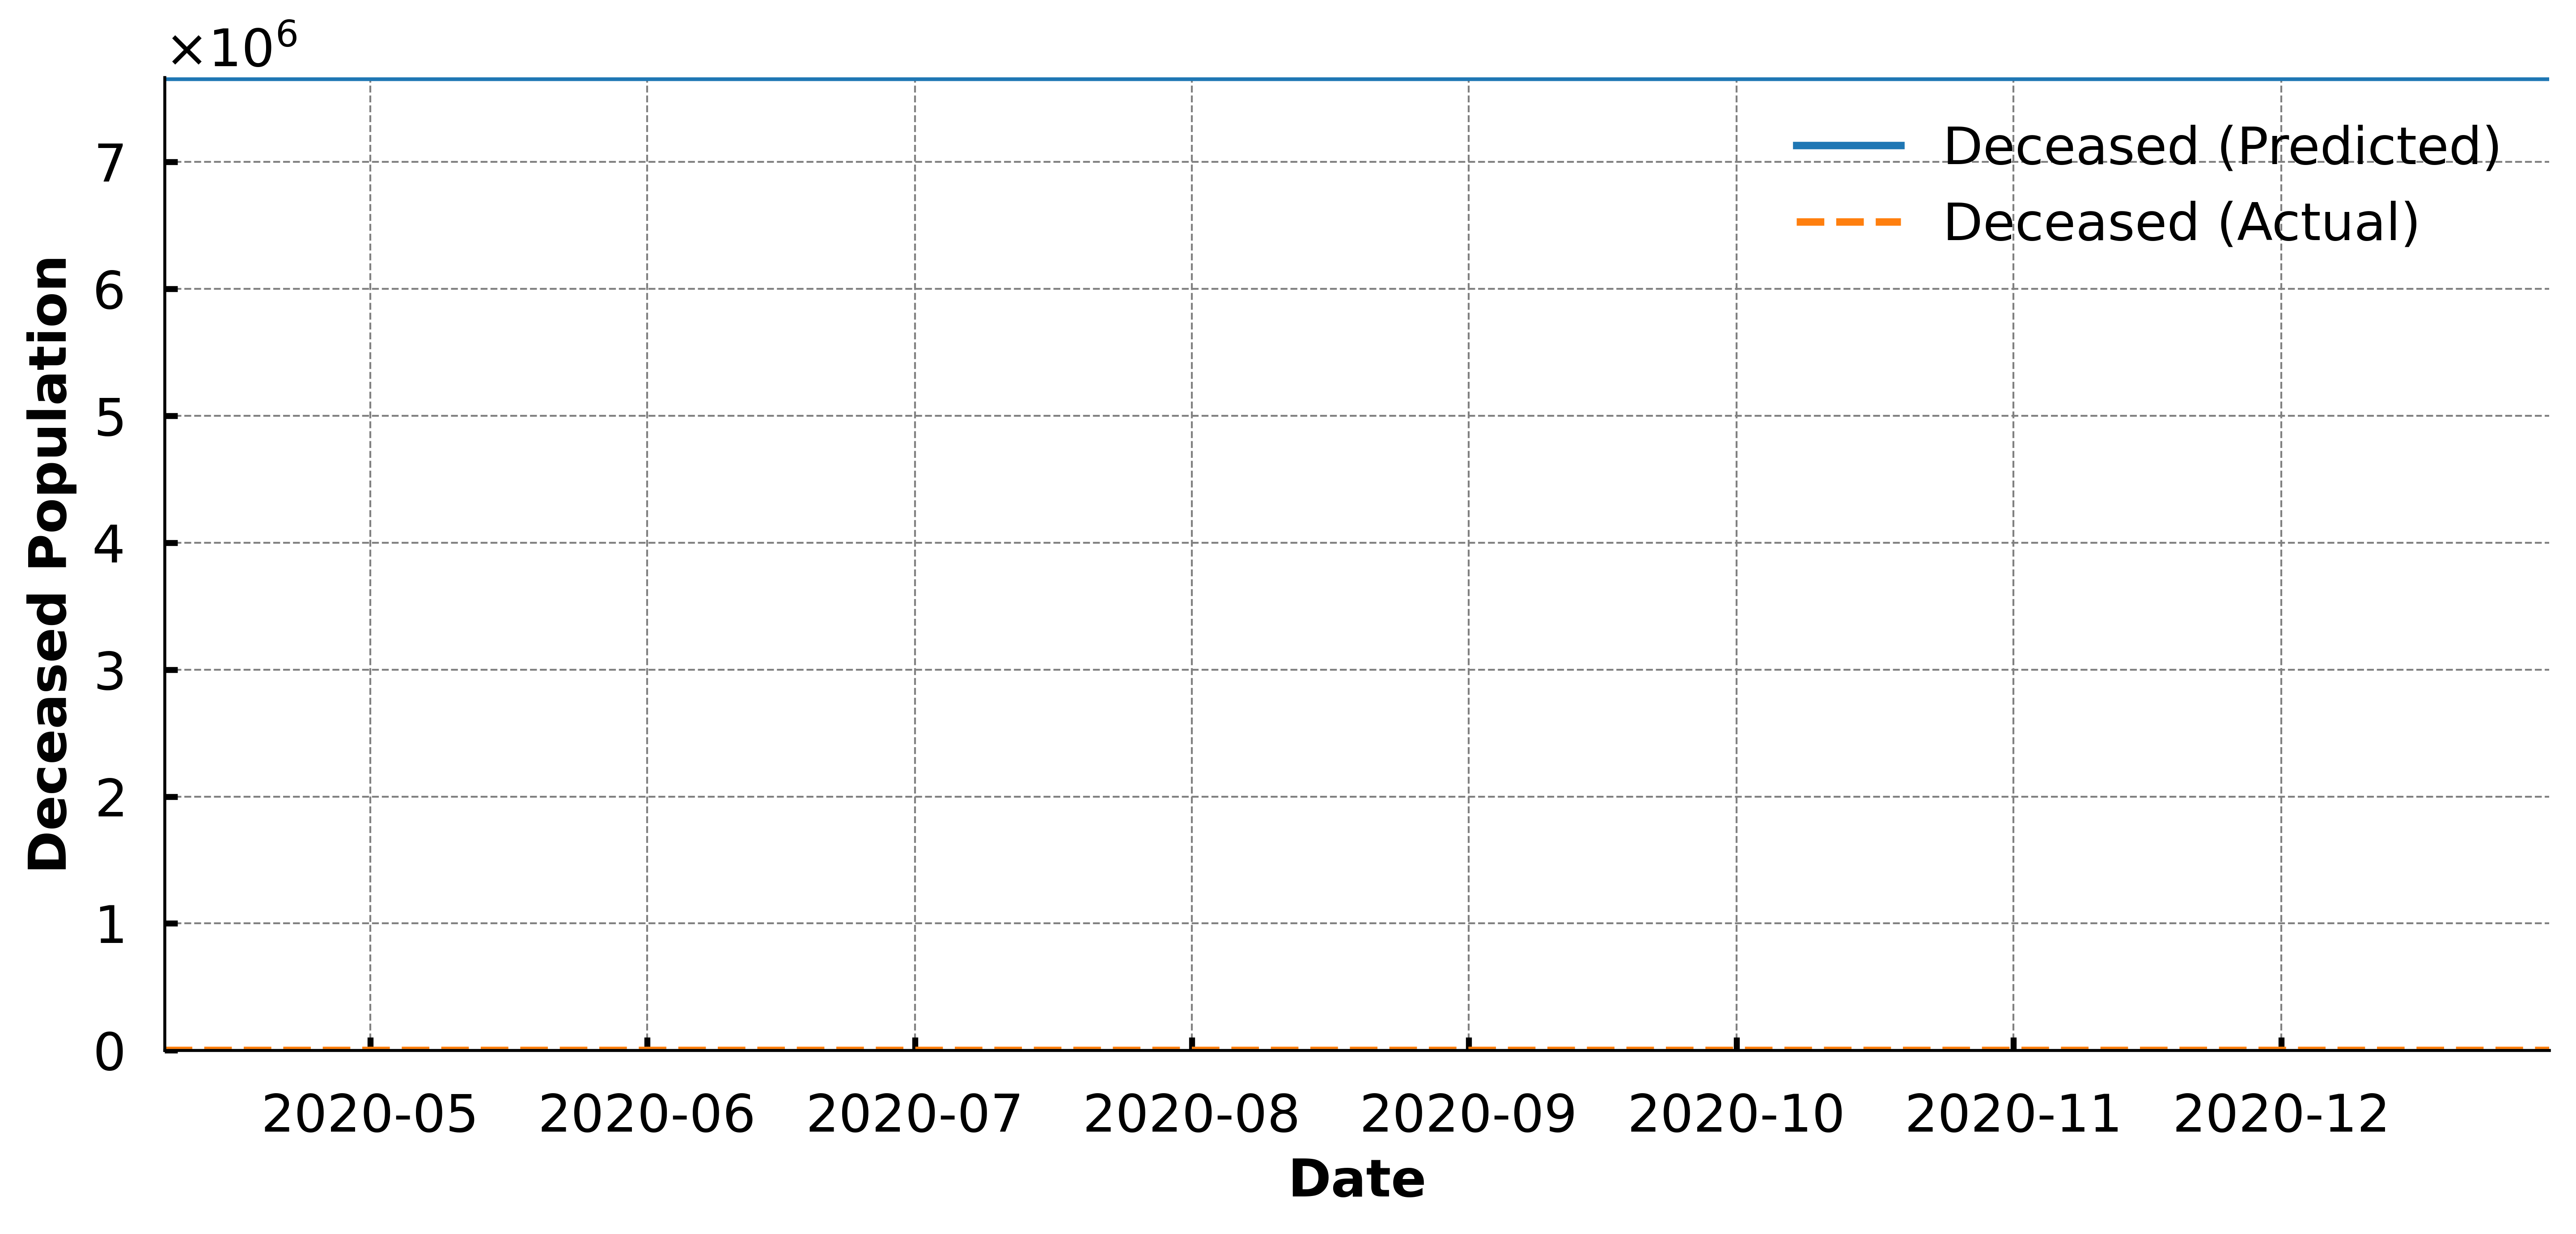

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["cumulative_confirmed"] - df["cumulative_deceased"] - df["recovered"]

    cols_to_smooth = ["S(t)","cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

def SEIRD_model(t, y, beta, gamma, mu, sigma, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, S, I, R, D

def scale_data(data, features):
    """Scale the data using MinMaxScaler."""
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features)
    return scaled_data, scaler  

# Define features and data split
features = ["S(t)", "active_cases", "recovered", "new_deceased"]

# Scale the data
scaled_data, scaler = scale_data(data, features)

# Prepare tensors
t_data, S_data, I_data, R_data, D_data = prepare_tensors(scaled_data, device)

class ModifiedTanh(nn.Module):
    def __init__(self, alpha, epsilon):
        super(ModifiedTanh, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon

    def forward(self, x):
        return torch.tanh(self.alpha * x) + self.epsilon

class StateNN(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, num_layers=4, hidden_neurons=20):
        super(StateNN, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

class ParamNN(nn.Module):
    """Neural network for predicting time-varying parameters."""
    def __init__(self, num_layers=4, hidden_neurons=20, alpha=1.0, epsilon=0.0):
        super(ParamNN, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon
        layers = [nn.Linear(1, hidden_neurons), ModifiedTanh(alpha, epsilon)]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), ModifiedTanh(alpha, epsilon)])
        layers.append(nn.Linear(hidden_neurons, 3))  # Adjust the output size to 3 (beta, gamma, mu)
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

def pinn_loss(t, data, state_nn, param_nn, N, sigma):
    """Physics-Informed Neural Network loss function."""
    
    # Predicted states
    states_pred = state_nn(t)
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]
    
    # Compute gradients
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # Predicted parameters
    params_pred = param_nn(t)
    beta_pred, gamma_pred, mu_pred = params_pred[:, 0], params_pred[:, 1], params_pred[:, 2]
    
    # SEIRD model residuals
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta_pred, gamma_pred, mu_pred, sigma, N)
    
    # # Compute E dynamically
    # E_calculated = (I_t + (gamma_pred + mu_pred) * I_pred - sigma * E_pred) / sigma
    
    # Compute data loss (MSE_u)
    S_data, I_data, R_data, D_data = data
    loss_data = torch.mean((S_pred - S_data)**2) + torch.mean((I_pred - I_data)**2) + torch.mean((R_pred - R_data)**2) + torch.mean((D_pred - D_data)**2)
    
    # Compute physics loss (MSE_f)
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((E_t - dEdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)
    
    # initial conditions loss
    loss_init = torch.mean((S_pred[0] - S_data[0])**2) + torch.mean((I_pred[0] - I_data[0])**2) + torch.mean((R_pred[0] - R_data[0])**2) + torch.mean((D_pred[0] - D_data[0])**2)   
    
    # Total loss
    total_loss = loss_data + loss_physics + loss_init
    
    return total_loss

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Hyperparameters
learning_rate = 1e-4
num_epochs = 50000
sigma = 1/5
N = data["population"].values[0]
alpha = 0.5
epsilon = 0.1

# Instantiate the neural networks with custom activation function
state_nn = StateNN(num_layers=6, hidden_neurons=32).to(device)
param_nn = ParamNN(num_layers=6, hidden_neurons=32, alpha=alpha, epsilon=epsilon).to(device)

# Optimizers
optimizer_state = optim.Adam(state_nn.parameters(), lr=learning_rate)
optimizer_param = optim.Adam(param_nn.parameters(), lr=learning_rate)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Training loop
loss_history = []
for epoch in tqdm(range(num_epochs)):
    state_nn.train()
    param_nn.train()
    
    optimizer_state.zero_grad()
    optimizer_param.zero_grad()
    
    # Prepare time tensor
    t = torch.linspace(0, 1, steps=len(data)).view(-1, 1).to(device).requires_grad_(True)
    
    # Prepare data tensor
    S_data = torch.tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I_data = torch.tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R_data = torch.tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D_data = torch.tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    
    data_tensors = (S_data, I_data, R_data, D_data)
    
    # Compute loss
    loss = pinn_loss(t, data_tensors, state_nn, param_nn, N, sigma)
    
    # Backpropagation
    loss.backward()
    
    optimizer_state.step()
    optimizer_param.step()
    
    loss_history.append(loss.item())
    
    if epoch % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}")
    
    if early_stopping(loss.item()):
        print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
        break

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(np.log10(loss_history), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

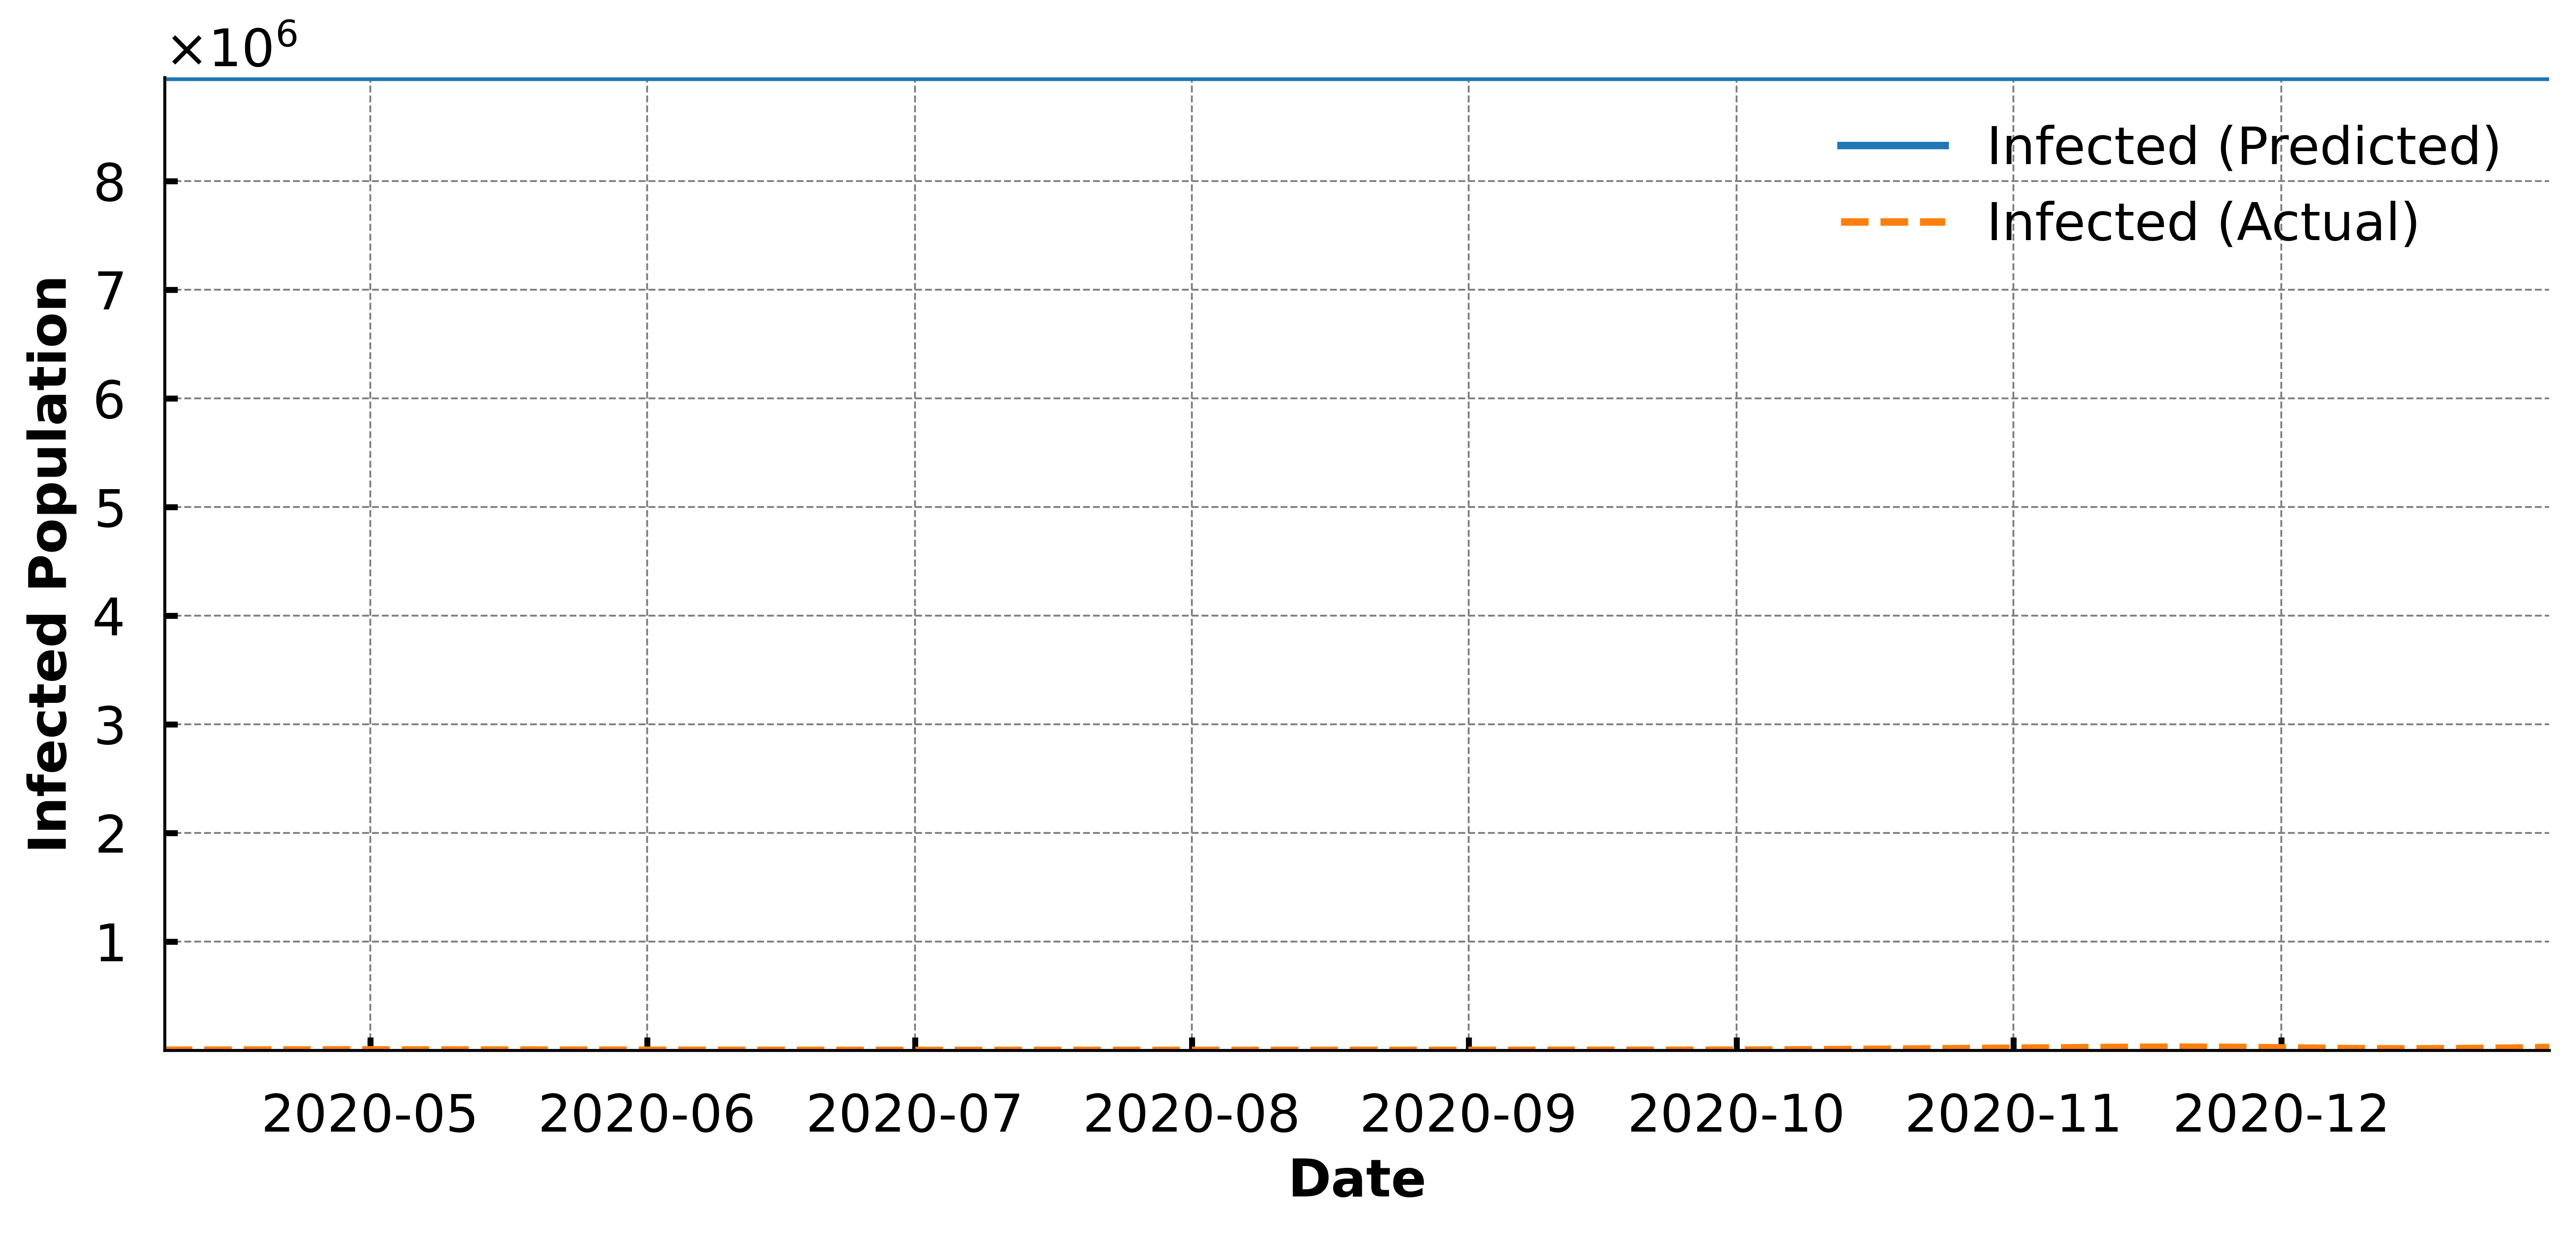

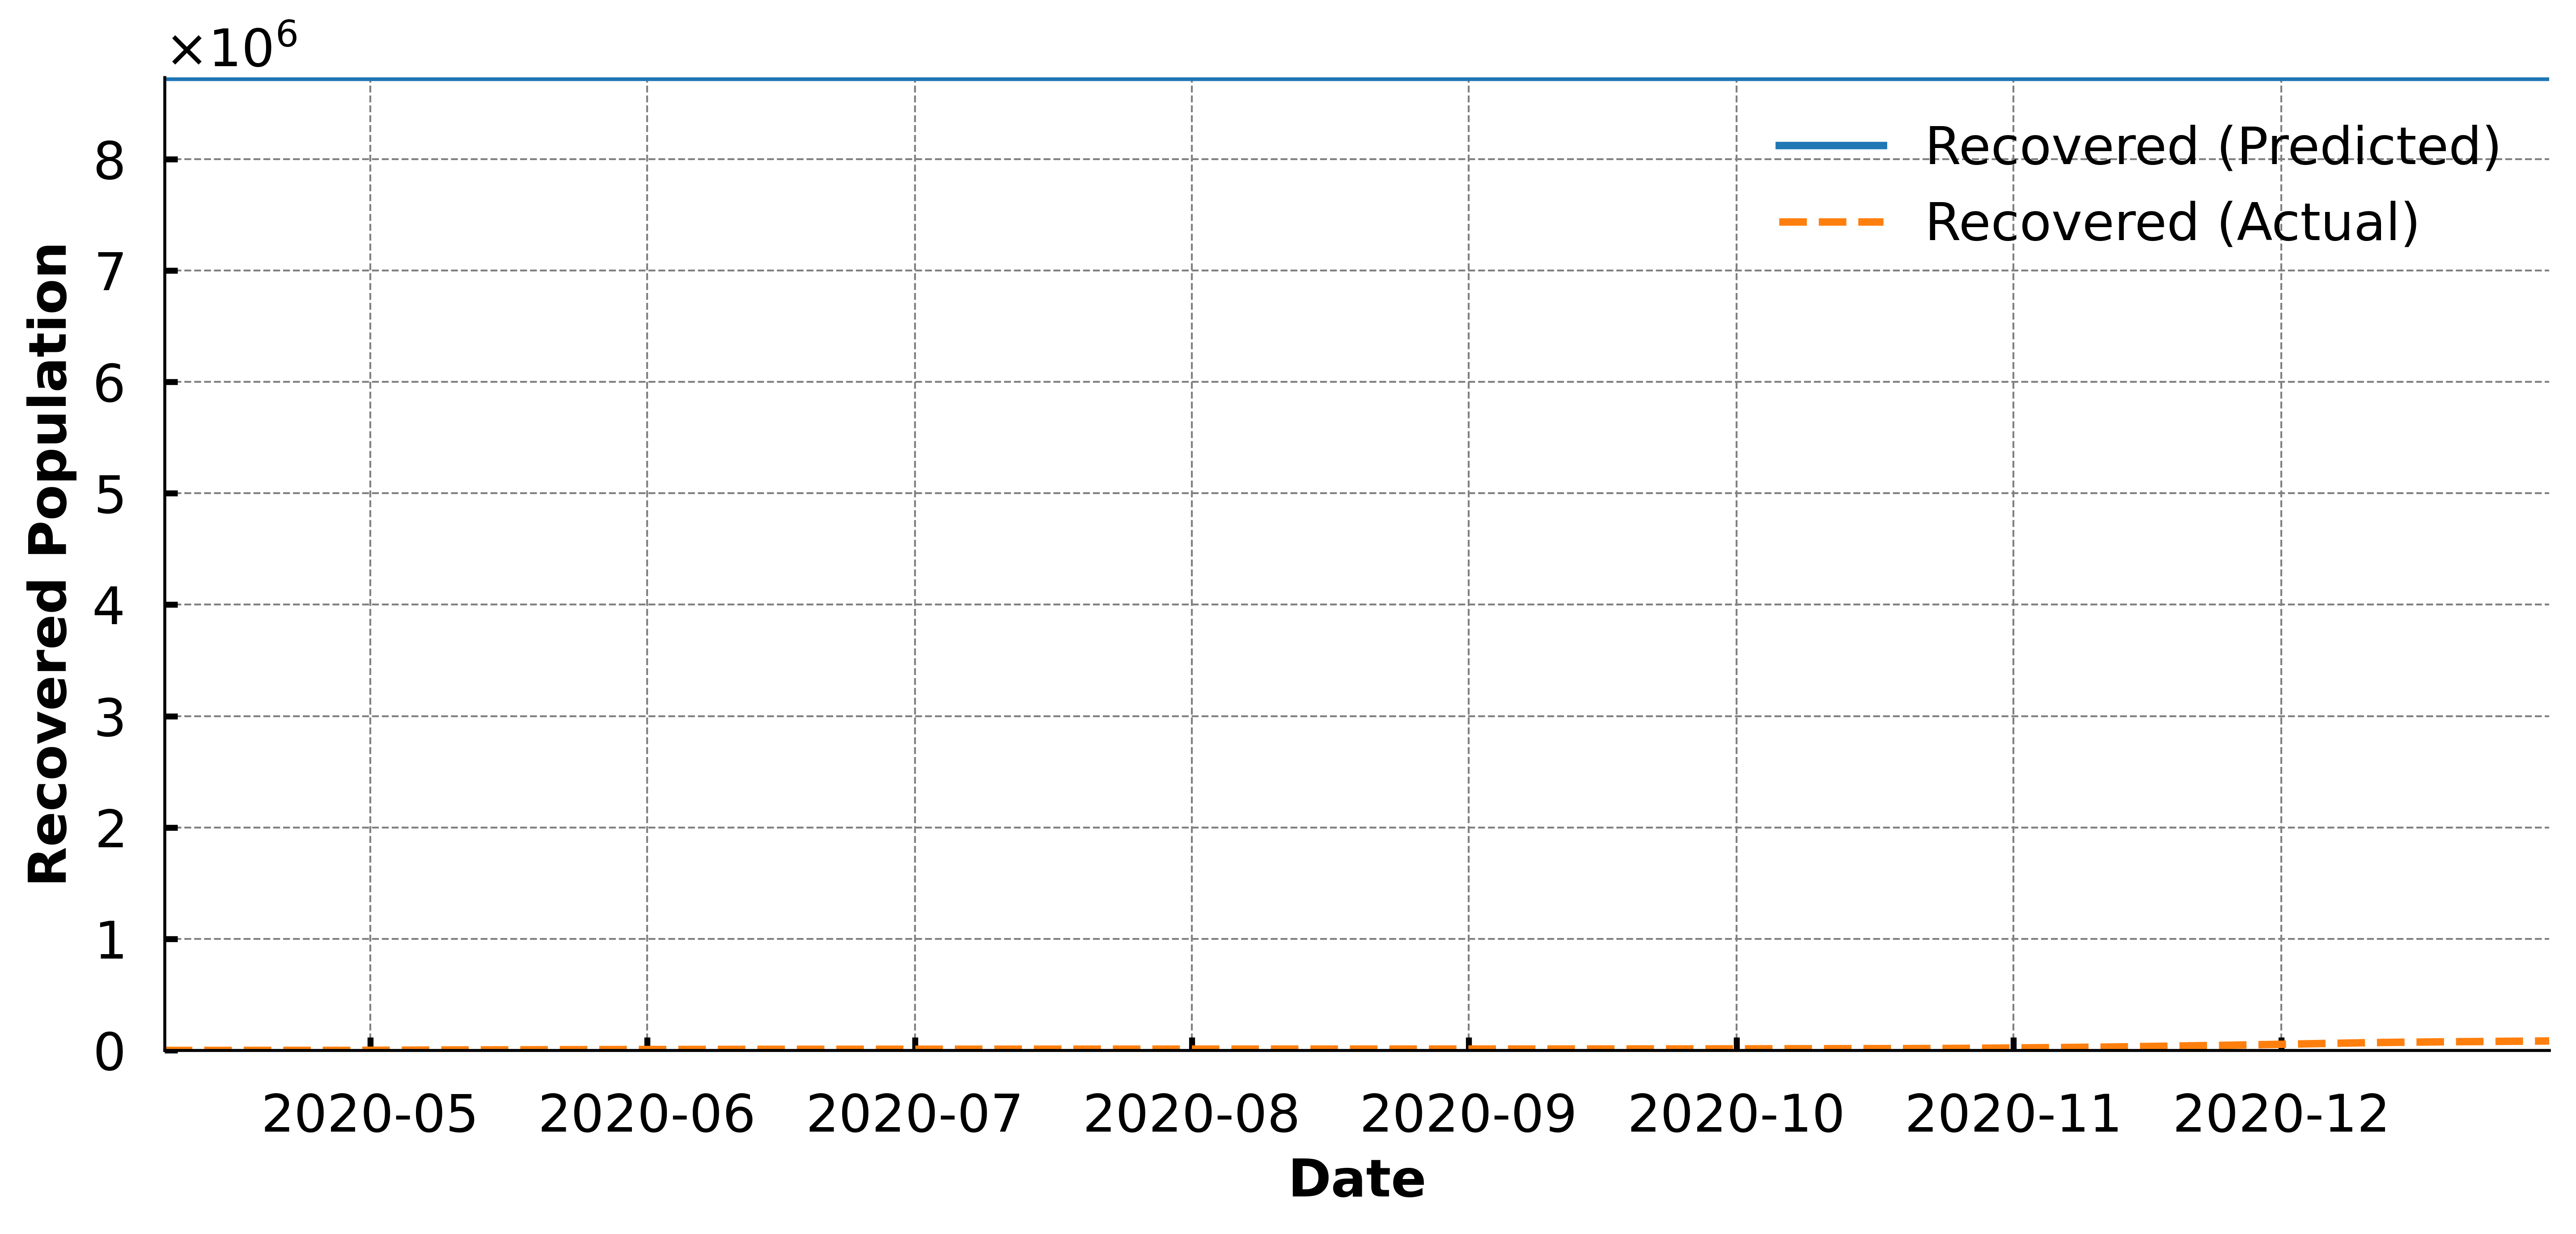

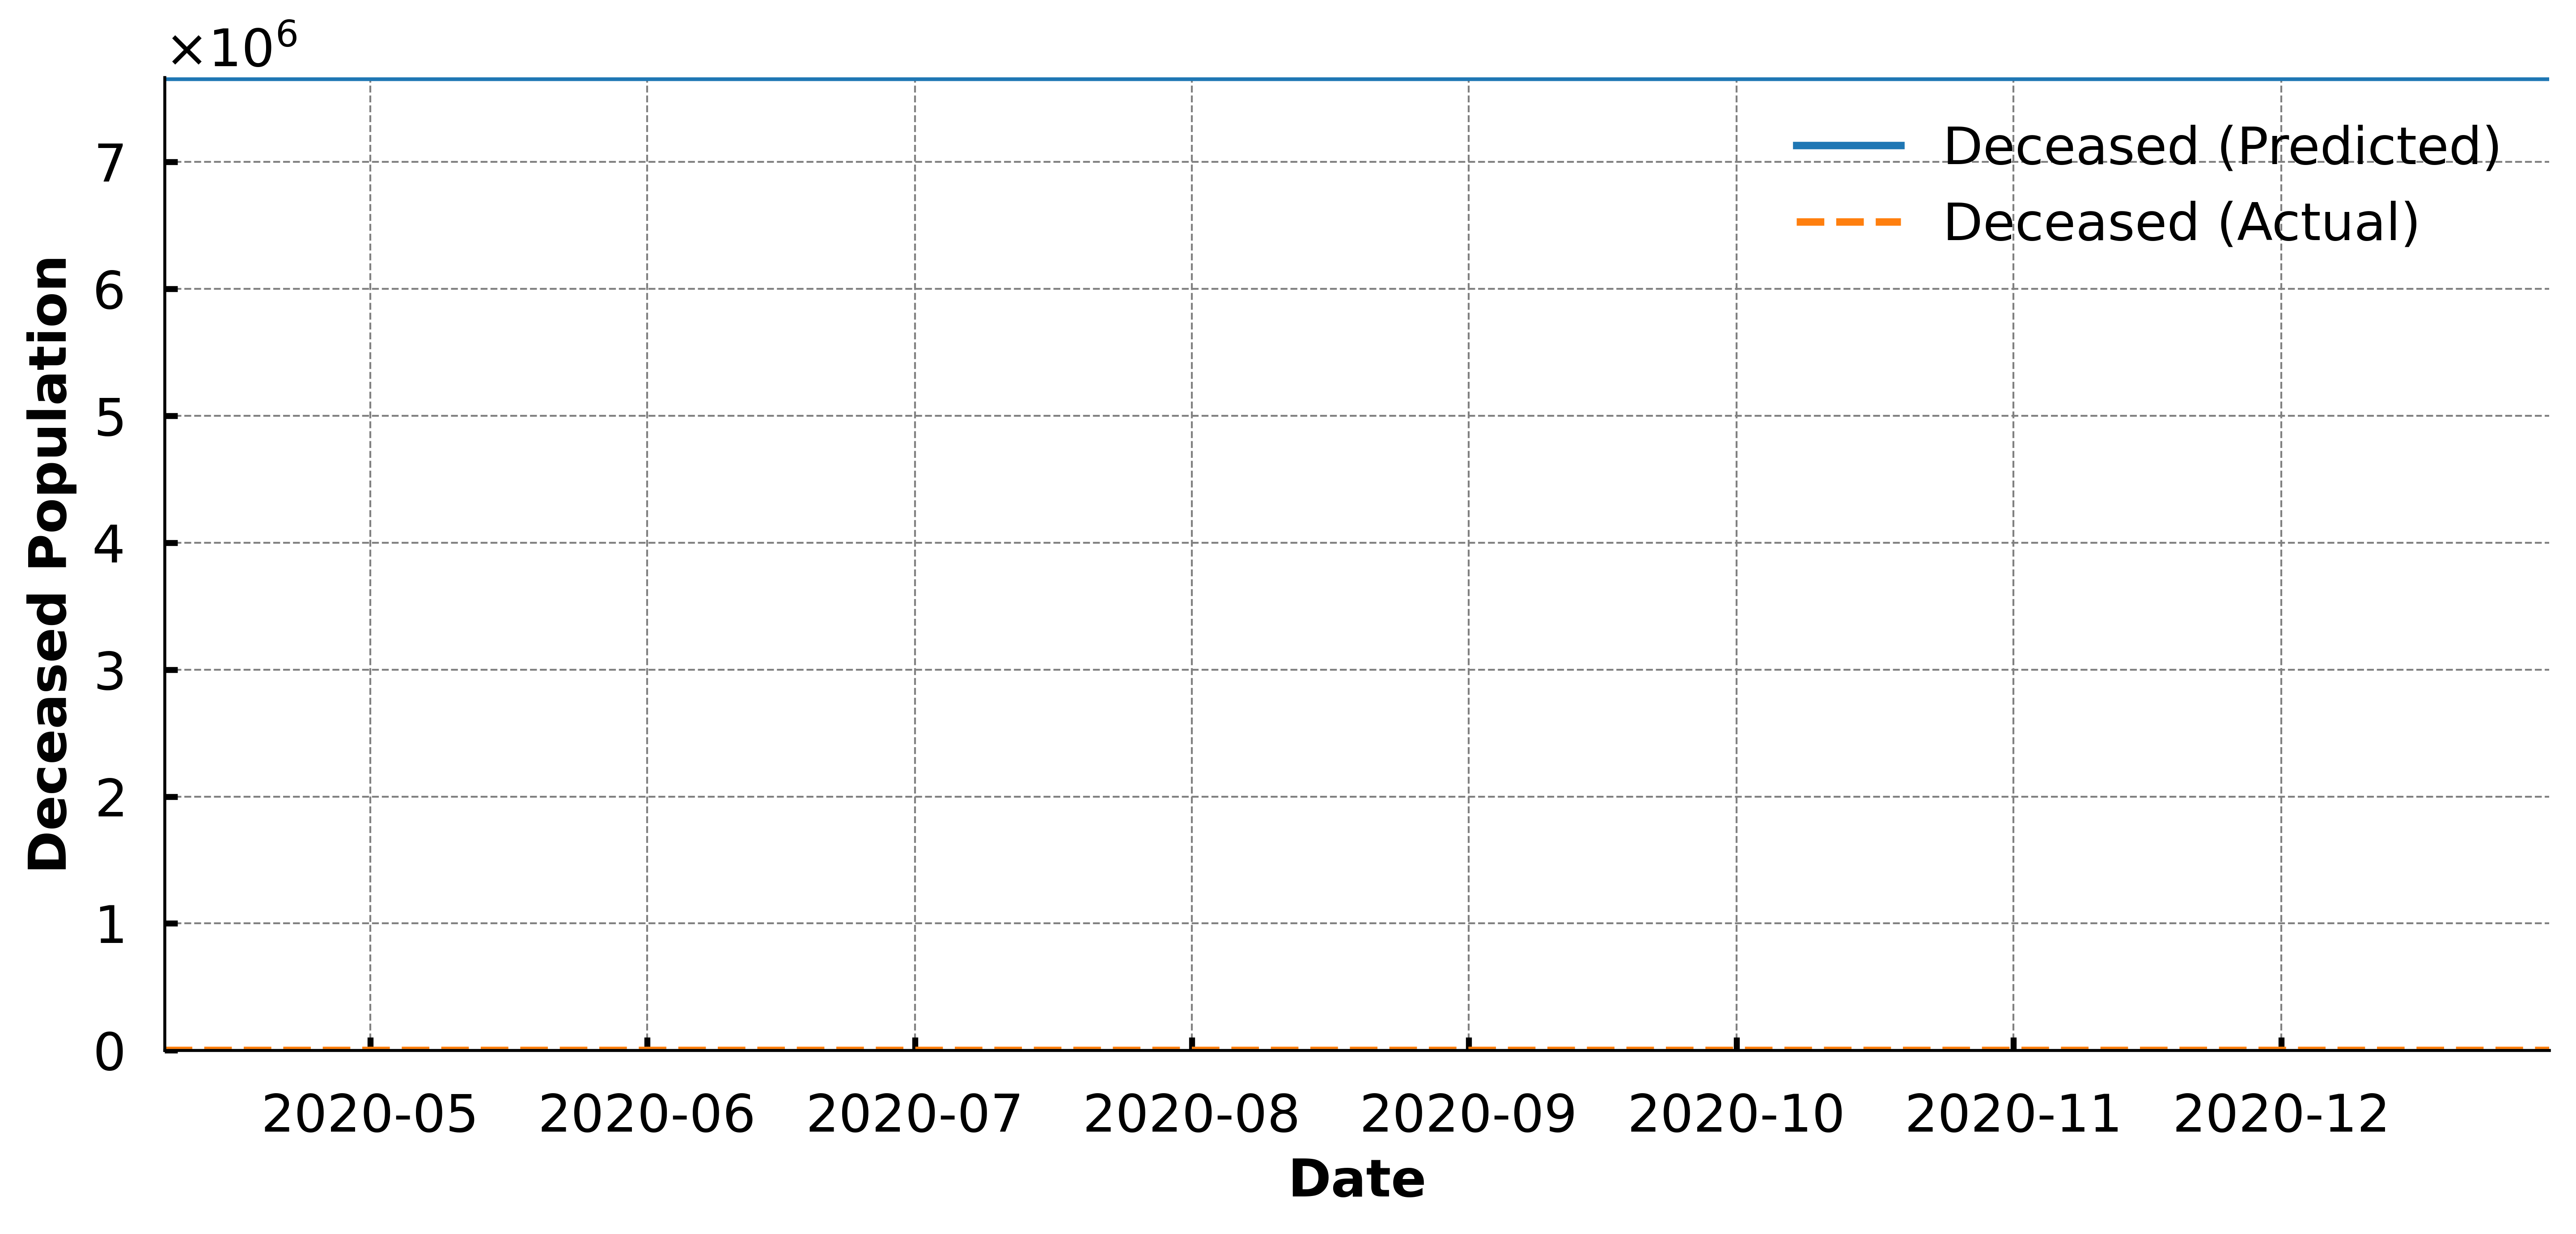

In [15]:
# Predict and plot the results
state_nn.eval()
param_nn.eval()

with torch.no_grad():
    t = torch.linspace(0, 1, steps=len(t_data)).view(-1, 1).to(device)
    states_pred = state_nn(t).cpu().numpy()
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]

    # Inverse transform to get back to original scale for each variable separately
    I_pred = scaler.inverse_transform(np.concatenate([I_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]
    R_pred = scaler.inverse_transform(np.concatenate([R_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]
    D_pred = scaler.inverse_transform(np.concatenate([D_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]

# Plot infected predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], I_pred, label='Infected (Predicted)')
plt.plot(data["date"], data["active_cases"], label='Infected (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Infected Population')
plt.legend()
plt.show()

# Plot recovered predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], R_pred, label='Recovered (Predicted)')
plt.plot(data["date"], data["recovered"], label='Recovered (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Recovered Population')
plt.legend()
plt.show()

# Plot deceased predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], D_pred, label='Deceased (Predicted)')
plt.plot(data["date"], data["new_deceased"], label='Deceased (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Deceased Population')
plt.legend()
plt.show()


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["cumulative_confirmed"] - df["cumulative_deceased"] - df["recovered"]

    cols_to_smooth = ["S(t)","cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

def SEIRD_model(t, y, beta, gamma, mu, sigma, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, S, I, R, D

def scale_data(data, features):
    """Scale the data using MinMaxScaler."""
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features)
    return scaled_data, scaler  

# Define features and data split
features = ["S(t)", "active_cases", "recovered", "new_deceased"]

# Scale the data
scaled_data, scaler = scale_data(data, features)

# Prepare tensors
t_data, S_data, I_data, R_data, D_data = prepare_tensors(scaled_data, device)

class ModifiedTanh(nn.Module):
    def __init__(self, alpha, epsilon):
        super(ModifiedTanh, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon

    def forward(self, x):
        return 0.5 * torch.tanh(self.alpha * x) + self.epsilon

class ResBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.activation = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        identity = x.clone()
        out = self.fc(x)
        out = self.activation(out)
        if out.shape == identity.shape:
            out = out + identity
        return out

class StateNN(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, num_layers=4, hidden_neurons=20):
        super(StateNN, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(ResBlock(hidden_neurons, hidden_neurons))
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        return self.net(t)

class ParamNN(nn.Module):
    """Neural network for predicting time-varying parameters."""
    def __init__(self, num_layers=4, hidden_neurons=20, alpha=1.0, epsilon=0.0):
        super(ParamNN, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon
        layers = [nn.Linear(1, hidden_neurons), ModifiedTanh(alpha, epsilon)]
        for _ in range(num_layers - 1):
            layers.append(ResBlock(hidden_neurons, hidden_neurons))
        layers.append(nn.Linear(hidden_neurons, 3))  # Adjust the output size to 3 (beta, gamma, mu)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        return self.net(t)

    def predict_parameters(self, t):
        params = self.net(t)
        # Ensure beta, gamma, and mu are in a valid range
        beta = torch.sigmoid(params[:, 0]) * 0.5  # range: [0, 0.5]
        gamma = torch.sigmoid(params[:, 1]) * 0.1  # range: [0, 0.1]
        mu = torch.sigmoid(params[:, 2]) * 0.1  # range: [0, 0.1]
        return beta, gamma, mu

def pinn_loss(t, data, state_nn, param_nn, N, sigma):
    """Physics-Informed Neural Network loss function."""
    
    # Predicted states
    states_pred = state_nn(t)
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]
    
    # Compute gradients
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True, retain_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True, retain_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True, retain_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True, retain_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True, retain_graph=True)[0]
    
    # Predicted parameters
    beta_pred, gamma_pred, mu_pred = param_nn.predict_parameters(t)
    
    # SEIRD model residuals
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta_pred, gamma_pred, mu_pred, sigma, N)
    
    # Compute data loss (MSE_u)
    S_data, I_data, R_data, D_data = data
    loss_data = torch.mean((S_pred - S_data)**2) + torch.mean((I_pred - I_data)**2) + torch.mean((R_pred - R_data)**2) + torch.mean((D_pred - D_data)**2)
    
    # Compute physics loss (MSE_f)
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)
    
    # initial conditions loss
    loss_init = torch.mean((S_pred[0] - S_data[0])**2) + torch.mean((I_pred[0] - I_data[0])**2) + torch.mean((R_pred[0] - R_data[0])**2) + torch.mean((D_pred[0] - D_data[0])**2)
    
    total_loss = loss_data + loss_physics + loss_init       
    
    return total_loss

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Hyperparameters
learning_rate = 1e-4
num_epochs = 50000
sigma = 1/5
N = data["population"].values[0]
alpha = 0.5
epsilon = 0.1

# Instantiate the neural networks with custom activation function
state_nn = StateNN(num_layers=6, hidden_neurons=32).to(device)
param_nn = ParamNN(num_layers=6, hidden_neurons=32, alpha=alpha, epsilon=epsilon).to(device)

# Optimizers
optimizer_state = optim.Adam(state_nn.parameters(), lr=learning_rate)
optimizer_param = optim.Adam(param_nn.parameters(), lr=learning_rate)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Training loop
loss_history = []
torch.autograd.set_detect_anomaly(True)
for epoch in tqdm(range(num_epochs)):
    state_nn.train()
    param_nn.train()
    
    optimizer_state.zero_grad()
    optimizer_param.zero_grad()
    
    # Prepare time tensor
    t = t_data
    
    data_tensors = (S_data, I_data, R_data, D_data)
    # Compute loss
    loss = pinn_loss(t, data_tensors, state_nn, param_nn, N, sigma)
    
    # Backpropagation
    loss.backward()
    
    optimizer_state.step()
    optimizer_param.step()
    
    loss_history.append(loss.item())
    
    if epoch % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}")
    
    if early_stopping(loss.item()):
        print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
        break

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(np.log10(loss_history), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict and plot the results
state_nn.eval()
param_nn.eval()

with torch.no_grad():
    t = torch.linspace(0, 1, steps=len(t_data)).view(-1, 1).to(device)
    states_pred = state_nn(t).cpu().numpy()
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]

    # Inverse transform to get back to original scale for each variable separately
    I_pred = scaler.inverse_transform(np.concatenate([I_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]
    R_pred = scaler.inverse_transform(np.concatenate([R_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]
    D_pred = scaler.inverse_transform(np.concatenate([D_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]

# Plot infected predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], I_pred, label='Infected (Predicted)')
plt.plot(data["date"], data["active_cases"], label='Infected (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Infected Population')
plt.legend()
plt.show()

# Plot recovered predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], R_pred, label='Recovered (Predicted)')
plt.plot(data["date"], data["recovered"], label='Recovered (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Recovered Population')
plt.legend()
plt.show()

# Plot deceased predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], D_pred, label='Deceased (Predicted)')
plt.plot(data["date"], data["new_deceased"], label='Deceased (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Deceased Population')
plt.legend()
plt.show()


Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 0/50000 [00:00<?, ?it/s]